In [93]:
import pandas as pd
import wrangle as wr
import summaries as s
from importlib import reload
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.rcParams.update({'figure.dpi':120})
%config InlineBackend.figure_format = 'retina'

pd.options.display.float_format = '{:,.2f}'.format



ARIMA model in words:

Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)


In [2]:
df = s.get_summary_df(wr.get_clean_data(start2018=True))
#df = wr.add_date_features(sdf)

In [9]:
def create_customertype_subgroups(train):
    
    types = train[['purchase_amount','customer_type']]
    k_12= types[types["customer_type"]=='K-12']
    local_gov = types[types["customer_type"]=='Local Government']
    state_agency = types[types["customer_type"]=='State Agency']
    higher_ed = types[types["customer_type"]=='Higher Ed']
    other = types[(types['customer_type']=='Assistance Org') | (types['customer_type']=="Other")]
    
    return k_12, local_gov, state_agency, higher_ed, other

In [22]:
train, test = wr.split_data(df)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':].copy()

weekly res

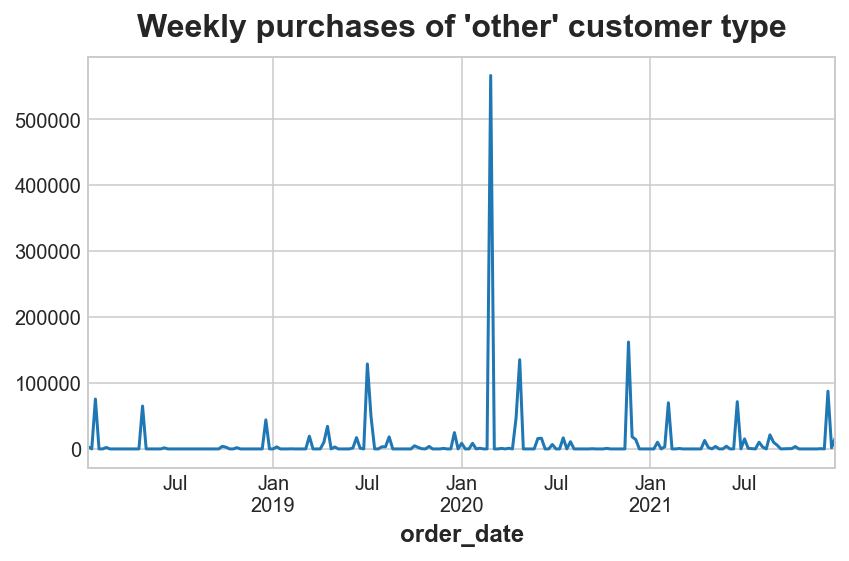

In [67]:
other.purchase_amount.resample('W').sum().plot()
plt.title('Weekly purchases of \'other\' customer type');

In [10]:
k_12, local_gov, state_agency, higher_ed, other = create_customertype_subgroups(train)
k_12v, local_govv, state_agencyv, higher_edv, otherv = create_customertype_subgroups(validate)
k_12t, local_govt, state_agencyt, higher_edt, othert = create_customertype_subgroups(test)

In [4]:
ts = train.purchase_amount.resample('D').sum()    

<AxesSubplot: xlabel='order_date'>

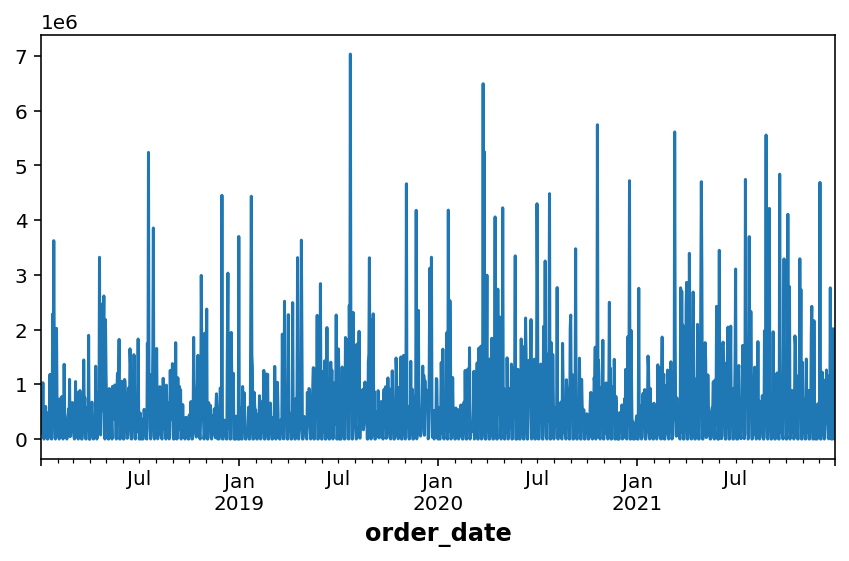

In [6]:
ts.plot()

Text(0.5, 1.0, 'Partial autocorrelation by day')

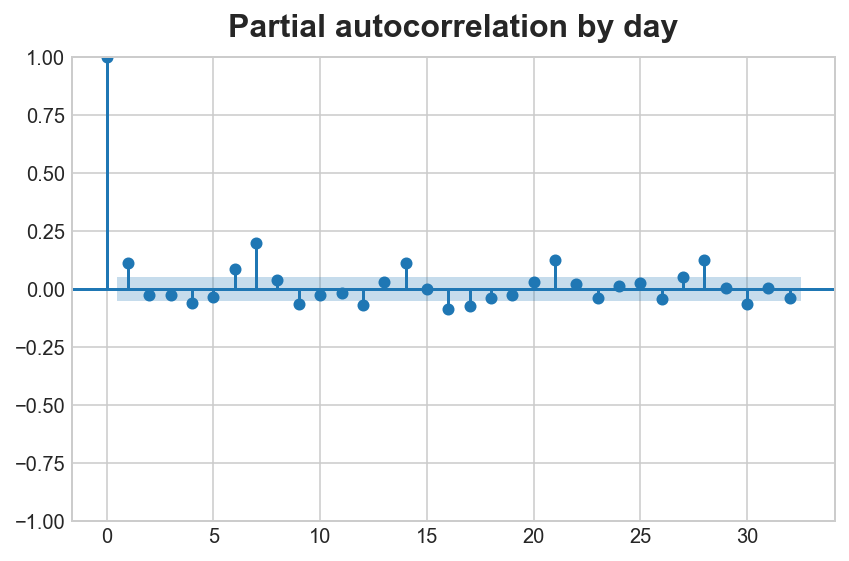

In [94]:
plot_pacf(train.purchase_amount.resample('D').sum(), method='yw')
plt.title('Partial autocorrelation by day')

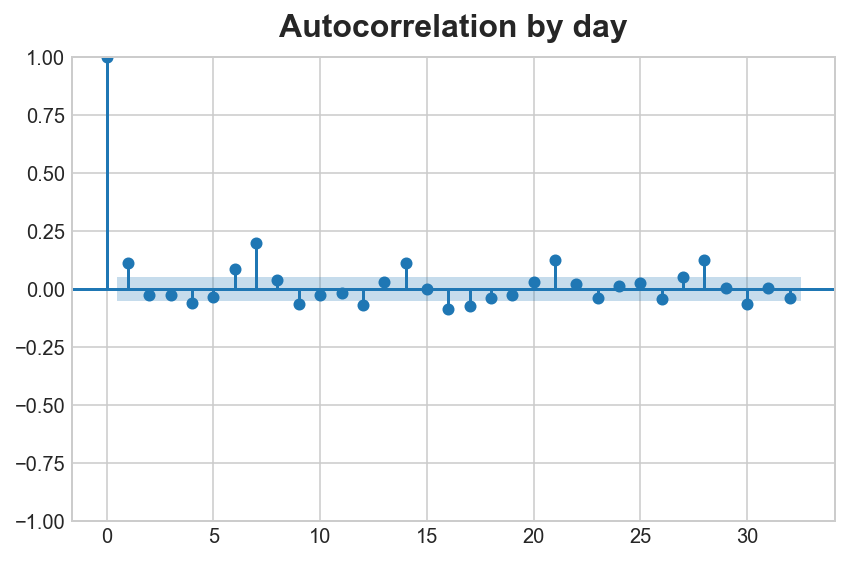

In [93]:
plot_pacf(train.purchase_amount.resample('D').sum(), method='yw')
plt.title('Autocorrelation by day')
None

Plots above show that the data is looking more like white noise

In [7]:
alpha = 0.5

In [11]:
types = {'All':train, "School Districts":k_12, 'Higher Education':higher_ed, \
        'Local Governments':local_gov, 'State Agencies': state_agency, 'Others':other}

In [12]:
stat_results_daily = pd.DataFrame(columns=['customer_type', 'ADF', 'p_value', 'stationarity'])
stationarity = ''
for t in types:
    results = adfuller(types[t]['purchase_amount'].resample('D').sum())
    p_value = round(results[1], 3)
    if p_value < alpha:
        stationarity = 'Stationary'
    else:
        stationarity = 'Non-Stationary'
    stat_results_daily.loc[len(stat_results_daily)] = [t, round(results[0], 3), p_value, stationarity]
display(stat_results_daily.set_index('customer_type'))

,ADF,p_value,stationarity
customer_type,,,
All,-7.85,0.00,Stationary
School Districts,-6.50,0.00,Stationary
Higher Education,-12.16,0.00,Stationary
Local Governments,-7.52,0.00,Stationary
State Agencies,-37.52,0.00,Stationary
Others,-38.10,0.00,Stationary


In [13]:
# same but with regression='ct'
stat_results_daily = pd.DataFrame(columns=['customer_type', 'ADF', 'p_value', 'stationarity'])
stationarity = ''
for t in types:
    results = adfuller(types[t]['purchase_amount'].resample('D').sum(), regression='ct')
    p_value = round(results[1], 3)
    if p_value < alpha:
        stationarity = 'Stationary'
    else:
        stationarity = 'Non-Stationary'
    stat_results_daily.loc[len(stat_results_daily)] = [t, round(results[0], 3), p_value, stationarity]
display(stat_results_daily.set_index('customer_type'))

,ADF,p_value,stationarity
customer_type,,,
All,-8.31,0.00,Stationary
School Districts,-6.68,0.00,Stationary
Higher Education,-12.15,0.00,Stationary
Local Governments,-7.72,0.00,Stationary
State Agencies,-37.65,0.00,Stationary
Others,-38.09,0.00,Stationary


#### For daily resampling all data is stationary without any trend

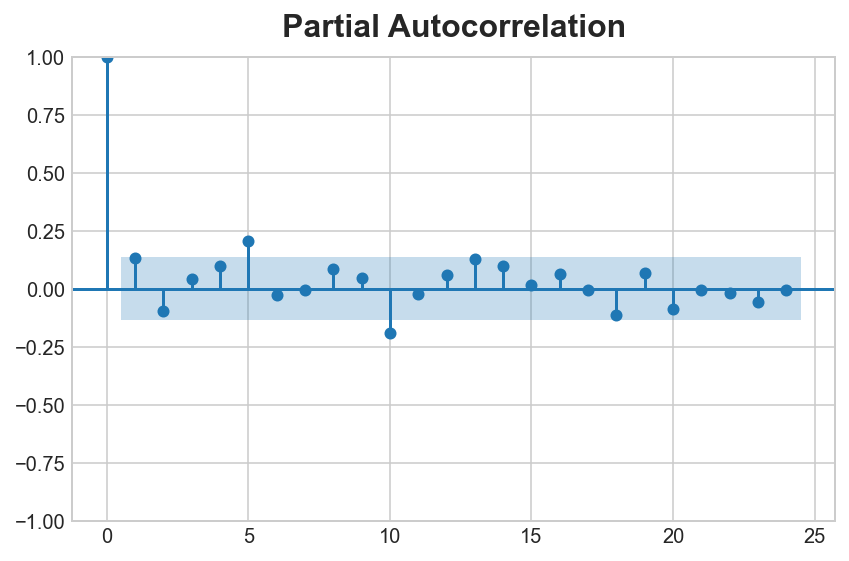

In [57]:
plot_pacf(ts, method='ywm')
None

In [105]:
from pmdarima.arima.utils import ndiffs

## Adf Test
print(f"ADF {ndiffs(ts, test='adf')}")  # 0

# KPSS test
print(f"KPSS {ndiffs(ts, test='kpss')}")  # 1

# PP test:
print(f"PP {ndiffs(ts, test='pp')}") # 0

ADF 0
KPSS 1
PP 0


In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
ARIMA?

In [15]:
ts.mean()

654835.7355890411

In [16]:
predictions_validate = validate.purchase_amount.resample('D').sum().to_frame()
predictions_validate['baseline'] = ts.mean()

In [142]:
predictions_validate

,purchase_amount,baseline
order_date,,
2022-01-01,"241,658.52","654,835.74"
2022-01-02,0.00,"654,835.74"
2022-01-03,"134,773.27","654,835.74"
2022-01-04,"74,142.07","654,835.74"
2022-01-05,"835,987.43","654,835.74"
...,...,...
2022-06-26,0.00,"654,835.74"
2022-06-27,"289,640.43","654,835.74"
2022-06-28,"546,076.95","654,835.74"


In [143]:
mean_squared_error(predictions_validate.purchase_amount, predictions_validate.baseline) ** 0.5

810253.4370466626

Daily resampling RMSE score for the baseline is 810,253

In [132]:
parameters = pd.DataFrame(columns=['p', 'd', 'q', 'rmse'])

In [ ]:
def model_arima(p:int=1, d:int=0, q:int=0):
    '''
    Create ARIMA model, fit results to train time series, predict validate time series
    Evaluate results
    Plot the predictions for the validate set agains the actual value
    Parameters are parameters for ARIMA model:
        p: int, the number of lag observations in the model, also known as the lag order. 
        d: int, the number of times the raw observations are differenced; also known as the degree of differencing. 
        q: int, the size of the moving average window, also known as the order of the moving average.
    * default parameters for daily predictions are set to 1, 0, 0
    1 - the only lag that has correlation is 1 day
    0 - data is stationary, no trend
    0 - no MA window
    '''
    # create ARIMA model
    model = ARIMA(ts, order=(p, d, q))
    # model name to save predictions 
    model_name = f'ARIMA {p},{d},{q}'
    fit = model.fit()
    forecast = fit.forecast(len(X_validate_ts))
    predictions_validate[model_name] = forecast
    evaluate_rmse(target, model_name, train=False)
    #
    X_validate_ts.plot()
    forecast.plot(label='predictions')
    plt.title('Predictions of ARIMA model')
    plt.show()

In [25]:
model = ARIMA(ts, order=(4, 1, 1))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:        purchase_amount   No. Observations:                 1460
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -22040.482
Date:                Sun, 29 Jan 2023   AIC                          44092.965
Time:                        09:38:09   BIC                          44124.678
Sample:                    01-02-2018   HQIC                         44104.795
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1006      0.033      3.024      0.002       0.035       0.166
ar.L2         -0.0341      0.024     -1.444      0.149      -0.080       0.012
ar.L3         -0.0284      0.033     -0.860      0.3

__Plot residuals:__
- Good model should have residuals looking like noise and their mean should be next to 0

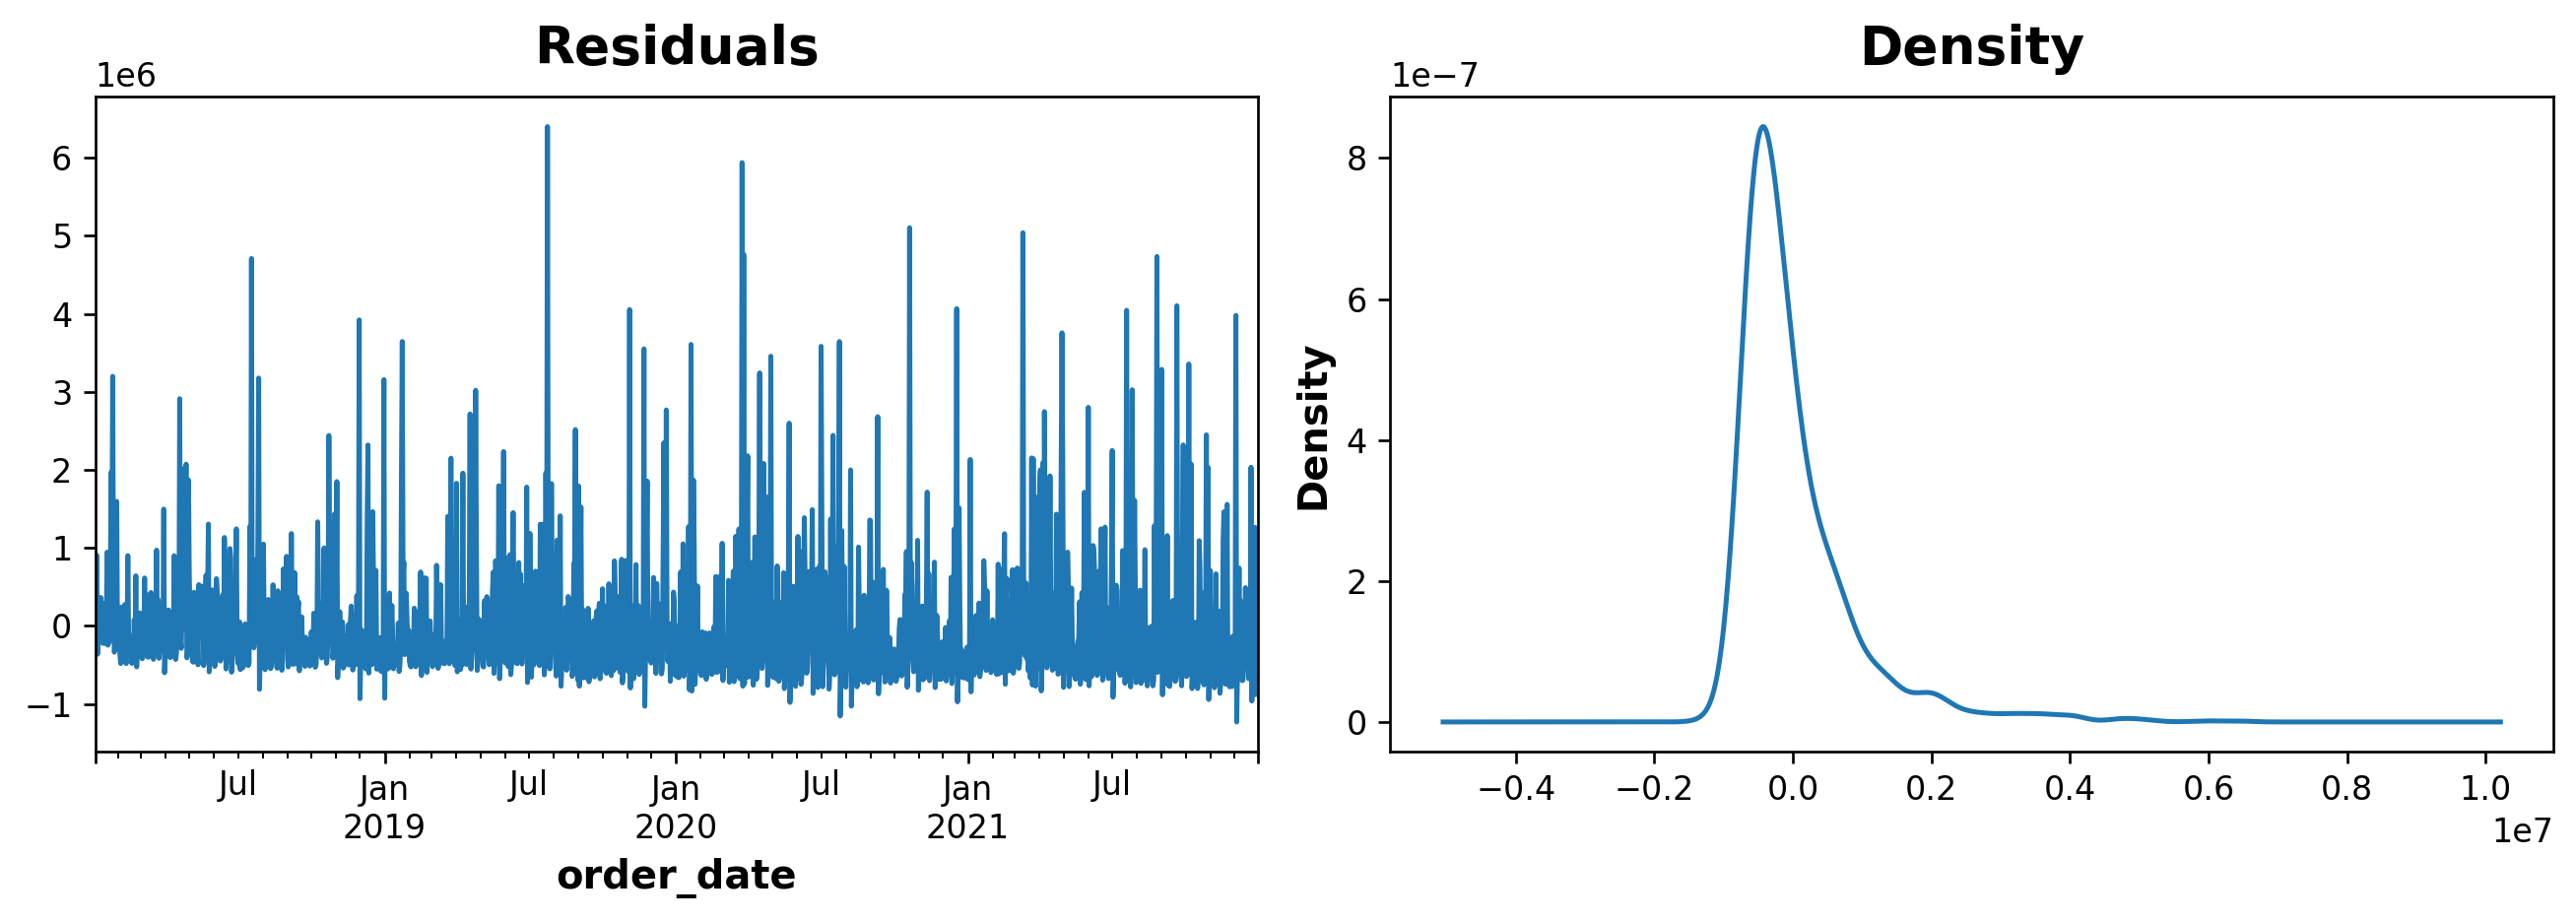

In [26]:
residuals = fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1]);

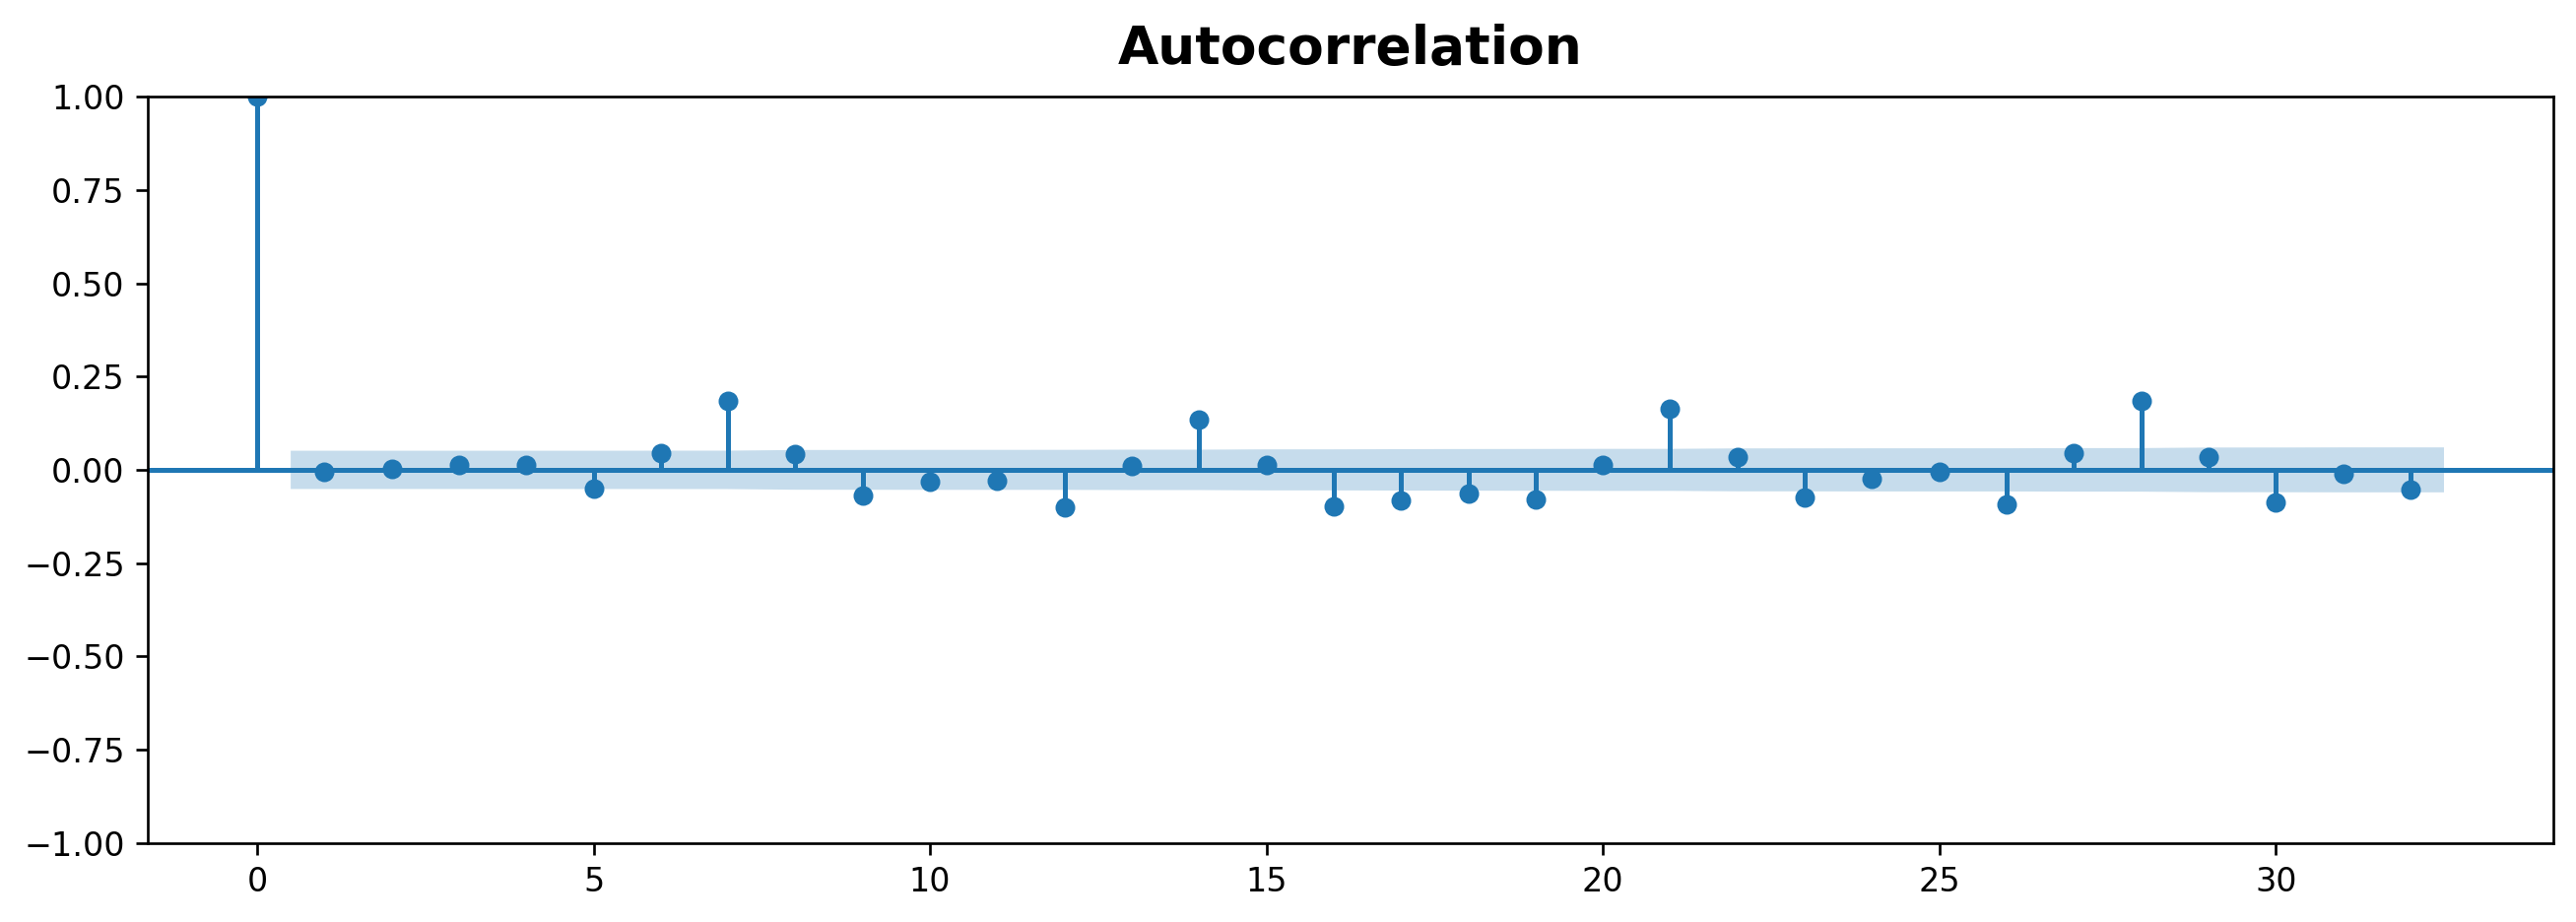

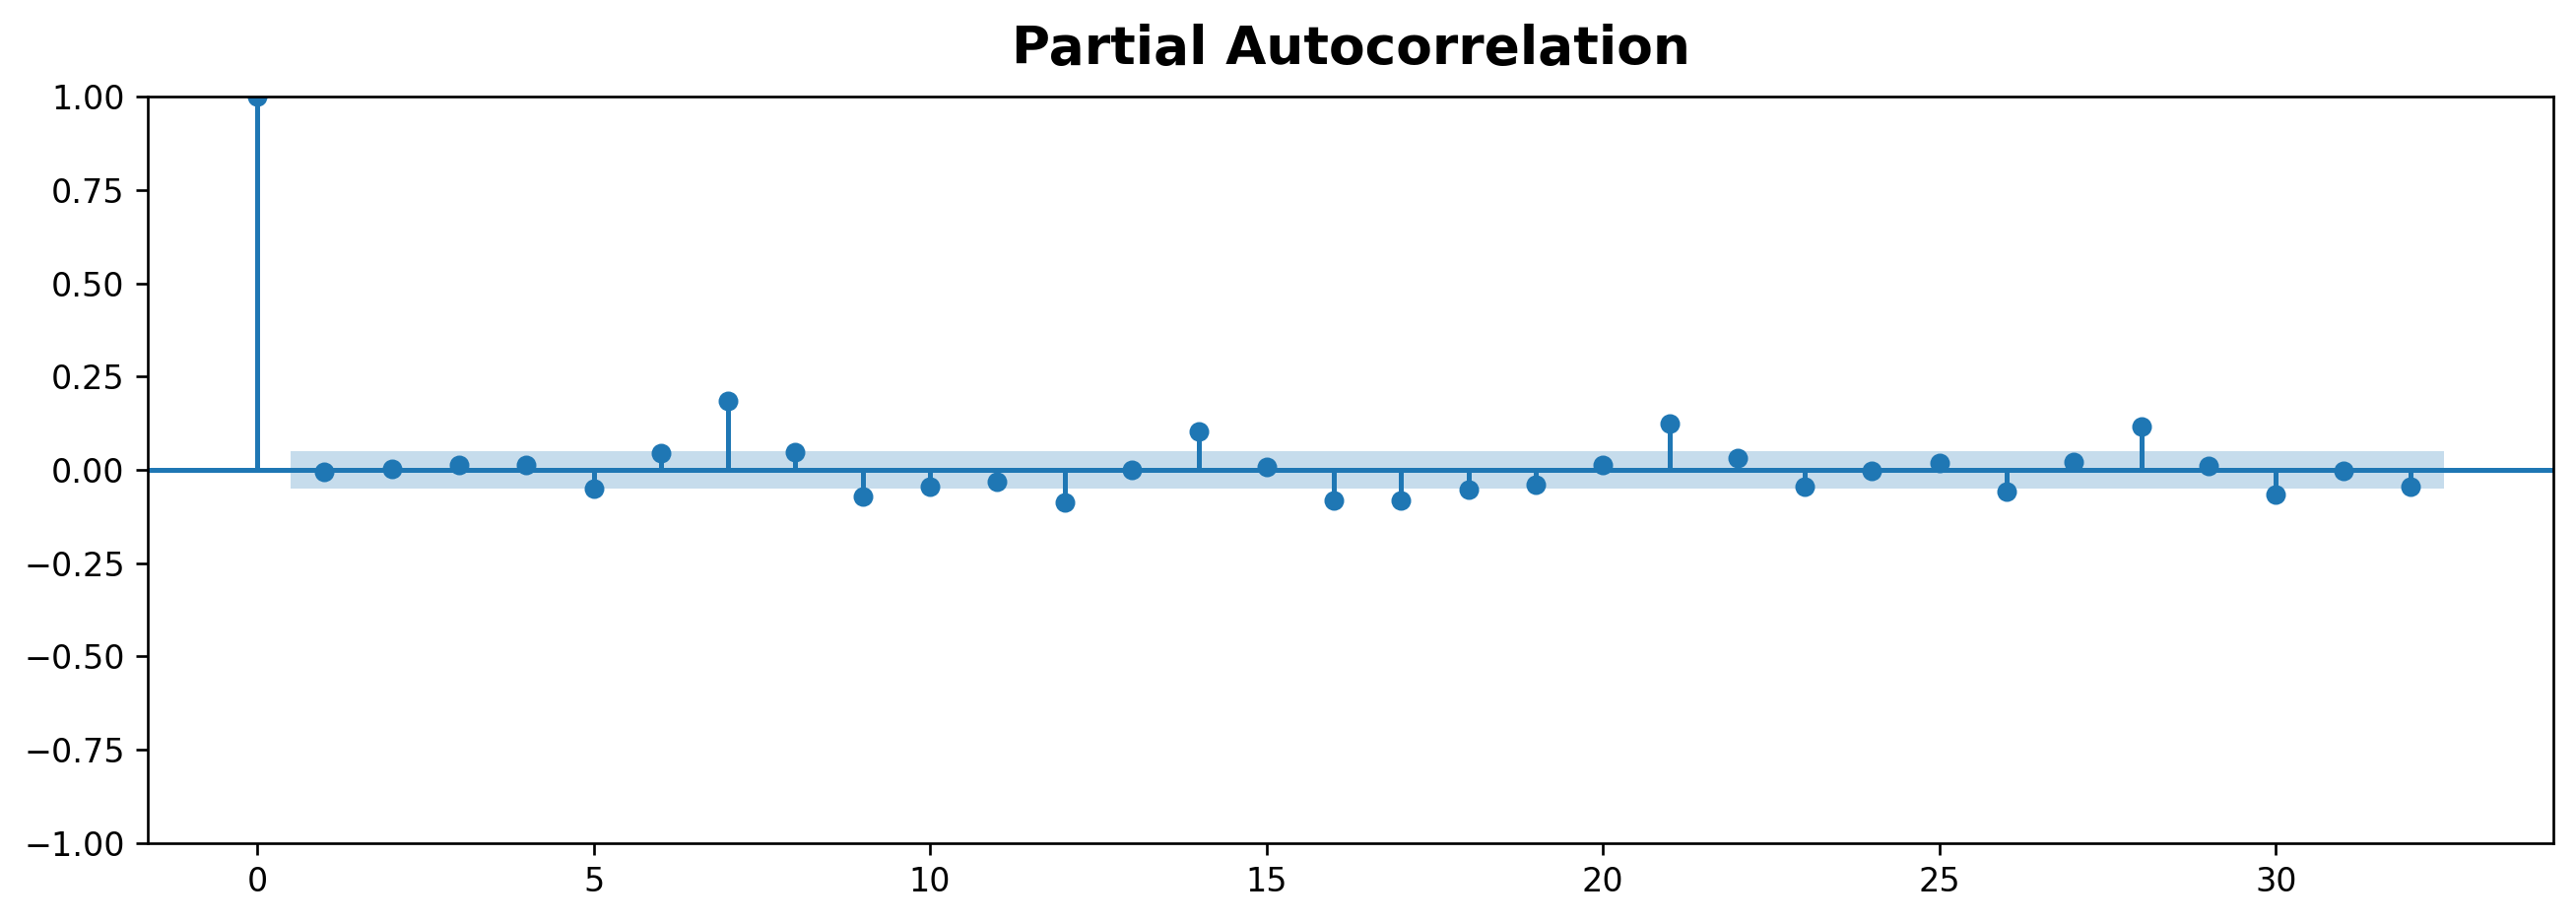

In [27]:
plot_acf(residuals)
plot_pacf(residuals, method='yw')
None

<AxesSubplot: xlabel='order_date'>

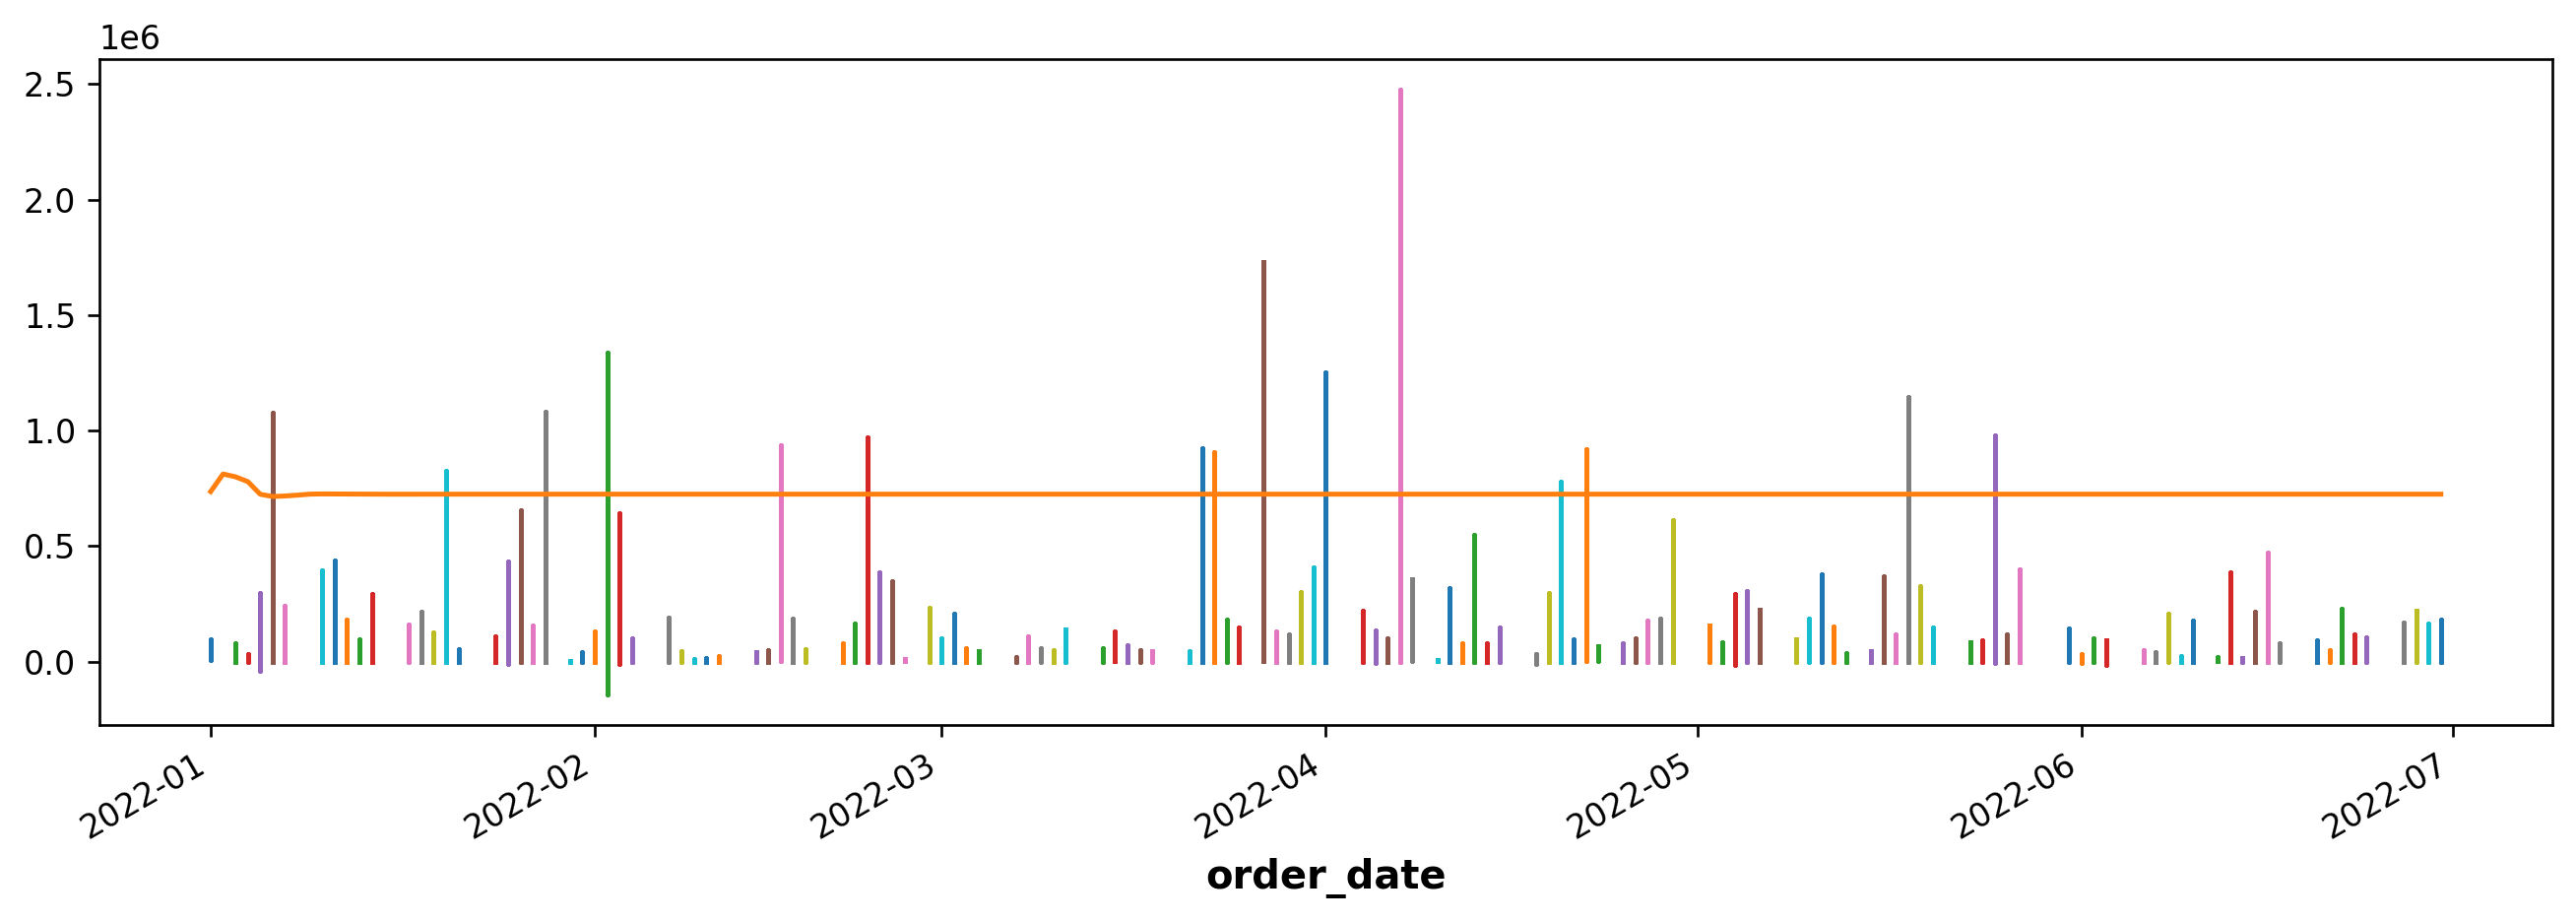

In [29]:
forecast = fit.forecast(len(validate.purchase_amount.resample('D')))
validate.purchase_amount.resample('D').plot()
forecast.plot()

In [30]:
forecast

2022-01-01   736,437.01
2022-01-02   812,353.74
2022-01-03   800,326.90
2022-01-04   779,353.72
2022-01-05   724,763.07
                ...    
2022-06-26   725,124.18
2022-06-27   725,124.18
2022-06-28   725,124.18
2022-06-29   725,124.18
2022-06-30   725,124.18
Freq: D, Name: predicted_mean, Length: 181, dtype: float64

In [33]:
predictions_validate['ARIMA 1,0,0'] = forecast

In [34]:
predictions_validate

,purchase_amount,baseline,"ARIMA 1,0,0"
order_date,,,
2022-01-01,"241,658.52","654,835.74","736,437.01"
2022-01-02,0.00,"654,835.74","812,353.74"
2022-01-03,"134,773.27","654,835.74","800,326.90"
2022-01-04,"74,142.07","654,835.74","779,353.72"
2022-01-05,"835,987.43","654,835.74","724,763.07"
...,...,...,...
2022-06-26,0.00,"654,835.74","725,124.18"
2022-06-27,"289,640.43","654,835.74","725,124.18"
2022-06-28,"546,076.95","654,835.74","725,124.18"


In [31]:
len(predictions_validate)

181

In [250]:
parameters.loc[len(parameters)] = [4, 1, 1, 
                                   np.sqrt(mean_squared_error(predictions_validate.purchase_amount, forecast))]

In [251]:
parameters

,p,d,q,rmse
0,2.00,1.00,0.00,"932,729.67"
1,2.00,0.00,0.00,"810,169.22"
2,1.00,1.00,1.00,"825,207.71"
3,1.00,1.00,0.00,"942,067.73"
4,0.00,1.00,1.00,"825,308.81"
5,0.00,1.00,1.00,"825,257.86"
6,0.00,1.00,2.00,"825,257.86"
7,0.00,1.00,3.00,"825,428.50"
8,0.00,0.00,0.00,"810,253.44"
9,3.00,0.00,0.00,"810,377.53"


In [17]:
import pmdarima as pm

In [18]:
pm.auto_arima?

In [19]:
auto_arima = pm.auto_arima(ts, stepwise=False, stationary=True, seasonal=False, m=52)

/usr/local/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (52) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_m

In [20]:
auto_arima

ARIMA(order=(0, 0, 5), scoring_args={}, suppress_warnings=True)

In [212]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1460
Model:               SARIMAX(0, 1, 5)   Log Likelihood              -22030.985
Date:                Sat, 28 Jan 2023   AIC                          44075.970
Time:                        18:57:20   BIC                          44112.969
Sample:                    01-02-2018   HQIC                         44089.773
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    560.7946    345.278      1.624      0.104    -115.938    1237.527
ma.L1         -0.8944      0.029    -30.732      0.000      -0.951      -0.837
ma.L2         -0.1184      0.033     -3.628      0.000      -0.182      -0.054
ma.L3          0.0048      0.033      0.144      0.886      -0.060       0.070
ma.L4         -0.0308      0.041     -0.750      0.453      -0.111       0.050
ma.L5          0.0497      0.032      1.554      0.120      -0.013       0.112
sigma2      8.347e+11    4.4e-06    1.9e+17      0.000    8.35e+11    8.35e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7365.12
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.09e+31. Standard errors may be unstable.
"""

__Best parameters__ for ARIMA were found with `pm.auto_arima(ts, stepwise=True, stationary=True, seasonal=False)`

__Exponential moving average provides better results__

### ARIMA WEEKLY RESAMPLING

In [256]:
# set ts to weekly resampling

In [254]:
ts = train.purchase_amount.resample('W').sum()

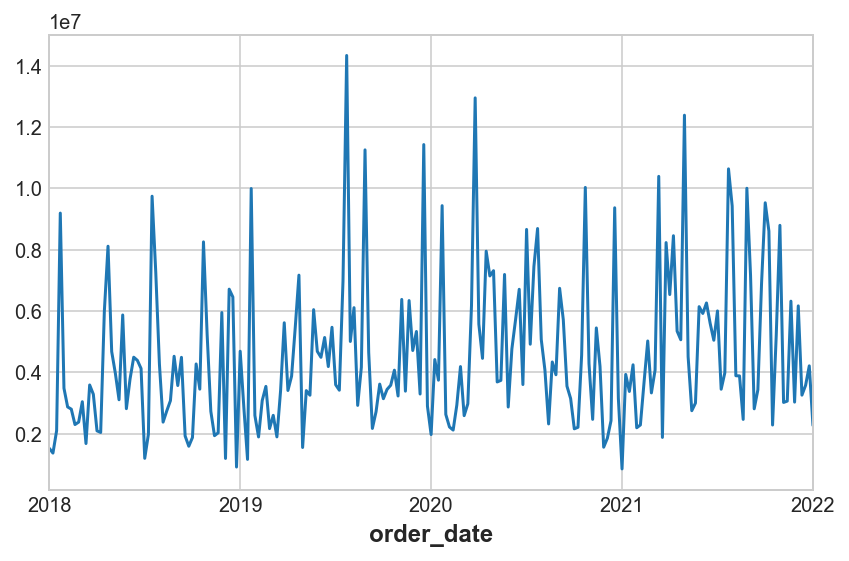

In [255]:
ts.plot();

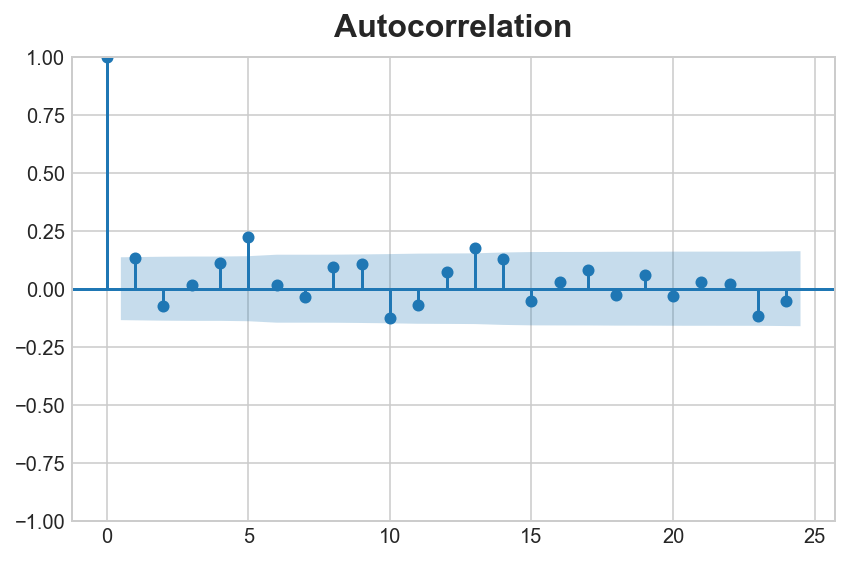

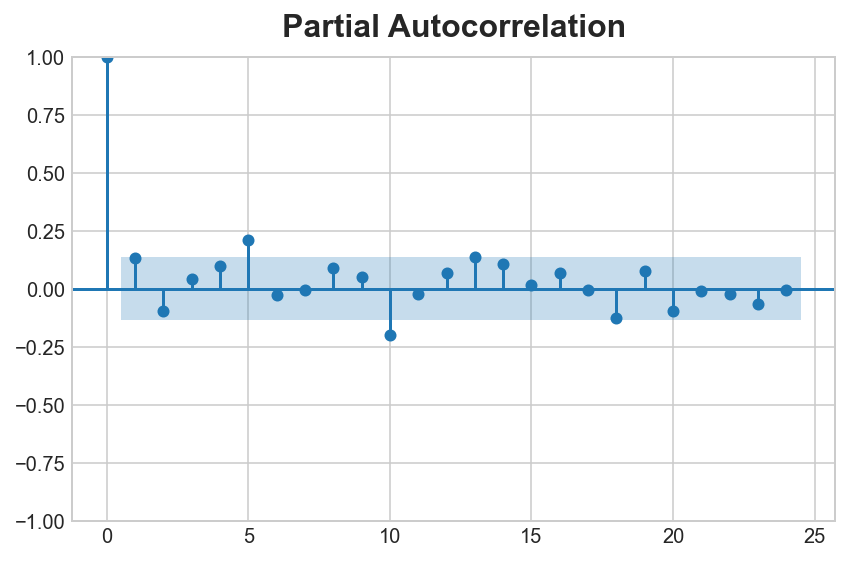

In [257]:
# look at ACF and PACF
plot_acf(ts)
plot_pacf(ts, method='yw')
None

In [258]:
# quick test for stationarity
## Adf Test
print(f"ADF {ndiffs(ts, test='adf')}")  # 0

# KPSS test
print(f"KPSS {ndiffs(ts, test='kpss')}")  # 1

# PP test:
print(f"PP {ndiffs(ts, test='pp')}") # 0

ADF 0
KPSS 1
PP 0


In [260]:
baseline = ts.mean()
predictions_validate = validate.purchase_amount.resample('W').sum().to_frame()
predictions_validate['baseline'] = ts.mean()
baseline # 4_574_450.59

4574450.593110048

In [265]:
print(f'RMSE baseline validate: \
    {mean_squared_error(predictions_validate.purchase_amount, predictions_validate.baseline) ** 0.5}')

RMSE baseline validate:     2446952.7824940197


In [262]:
parameters = pd.DataFrame(columns=['p', 'd', 'q', 'rmse'])

In [332]:
model = ARIMA(ts, order=(0, 0, 2))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:        purchase_amount   No. Observations:                  209
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -3372.224
Date:                Sat, 28 Jan 2023   AIC                           6752.448
Time:                        19:37:36   BIC                           6765.818
Sample:                    01-07-2018   HQIC                          6757.854
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.574e+06   1.85e+05     24.677      0.000    4.21e+06    4.94e+06
ma.L1          0.1505      0.075      2.020      0.043       0.004       0.297
ma.L2         -0.0747      0.079     -0.947      0.3

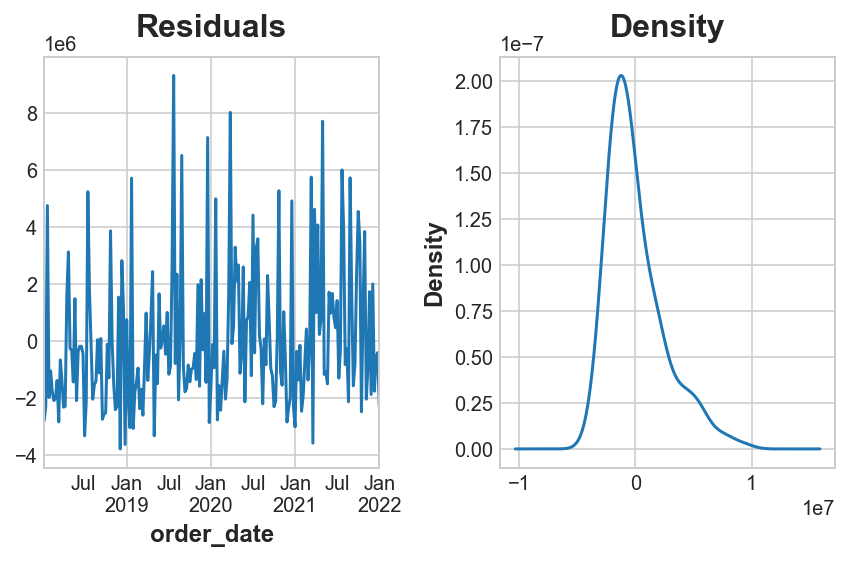

In [333]:
# plot residuals
residuals = fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1]);

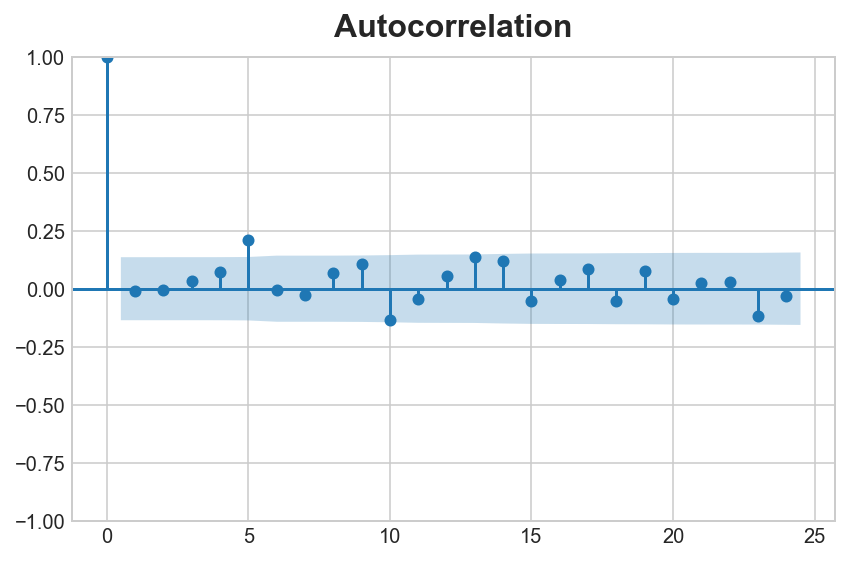

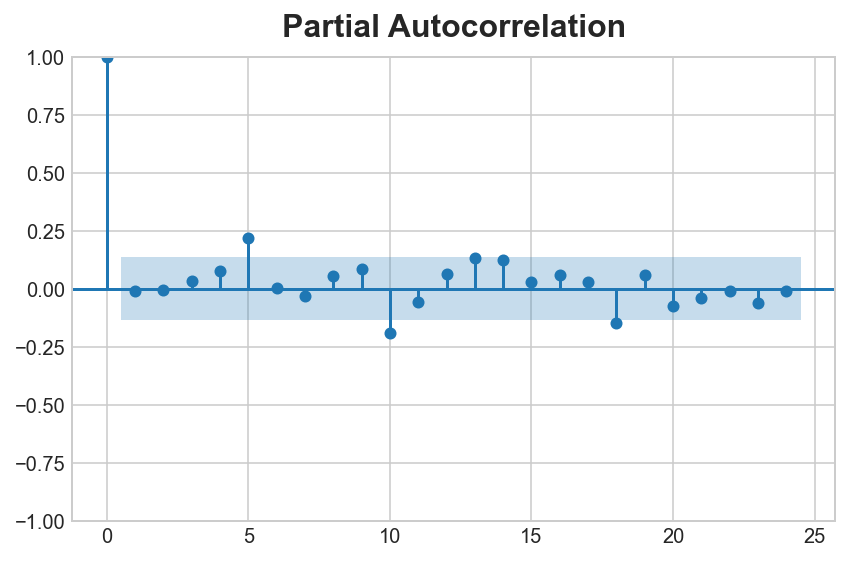

In [334]:
# plot residuals autocorrelation
plot_acf(residuals)
plot_pacf(residuals, method='yw')
None

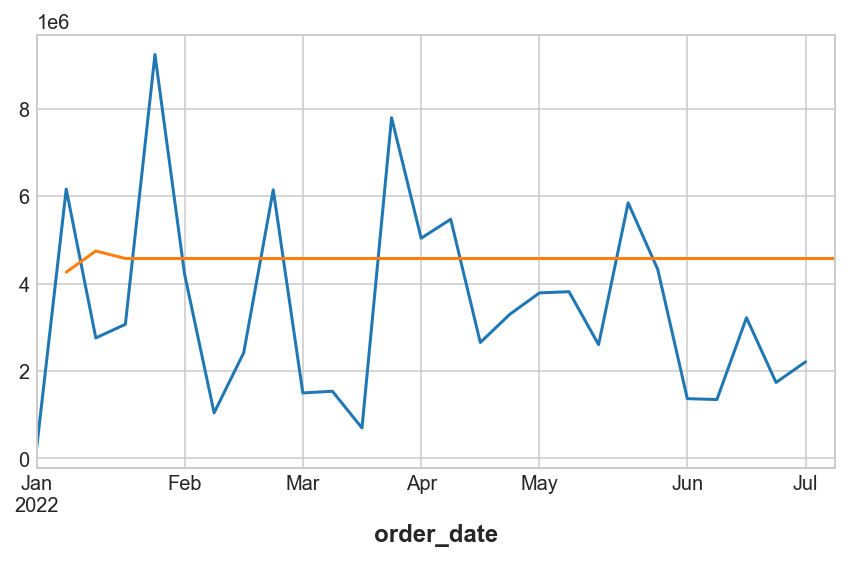

In [335]:
forecast = fit.forecast(len(validate.purchase_amount.resample('W').sum()))
validate.purchase_amount.resample('W').sum().plot()
forecast.plot();

In [336]:
parameters.loc[len(parameters)+1] = [0, 0, 2, 
                                   np.sqrt(mean_squared_error(predictions_validate.purchase_amount, forecast))]

In [337]:
parameters

,p,d,q,rmse
0,4.00,1.00,1.00,"2,680,945.96"
1,4.00,1.00,0.00,"2,240,644.14"
3,6.00,1.00,0.00,"2,249,622.35"
4,0.00,0.00,0.00,"2,446,952.78"
5,0.00,0.00,1.00,"2,424,079.88"
6,7.00,0.00,0.00,"2,467,905.97"
7,7.00,1.00,0.00,"2,246,168.15"
8,0.00,0.00,2.00,"2,423,110.95"


In [307]:
auto_arima = pm.auto_arima(ts, stepwise=True, stationary=True, seasonal=False)
print(auto_arima)
auto_arima.summary()

 ARIMA(0,0,1)(0,0,0)[0] intercept


/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3372.851
Date:                Sat, 28 Jan 2023   AIC                           6751.702
Time:                        19:29:41   BIC                           6761.729
Sample:                    01-07-2018   HQIC                          6755.756
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.541e+06   1.96e+05     23.201      0.000    4.16e+06    4.92e+06
ma.L1          0.1601      0.072      2.233      0.026       0.020       0.301
sigma2      5.998e+12      0.059   1.02e+14      0.000       6e+12       6e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                71.48
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             1.25
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.21e+28. Standard errors may be unstable.
"""

### ARIMA monthly resampling

In [338]:
# set ts to monthly resampling

In [339]:
ts = train.purchase_amount.resample('M').sum()

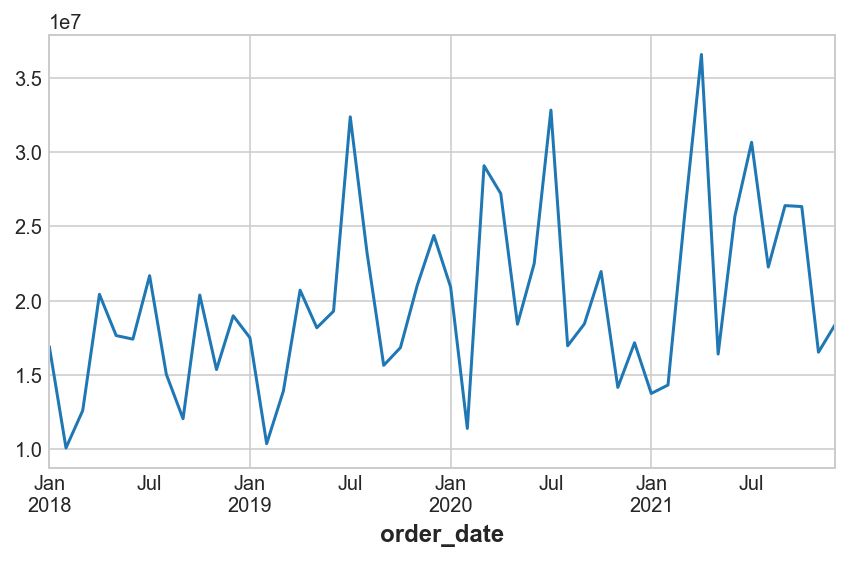

In [340]:
ts.plot();

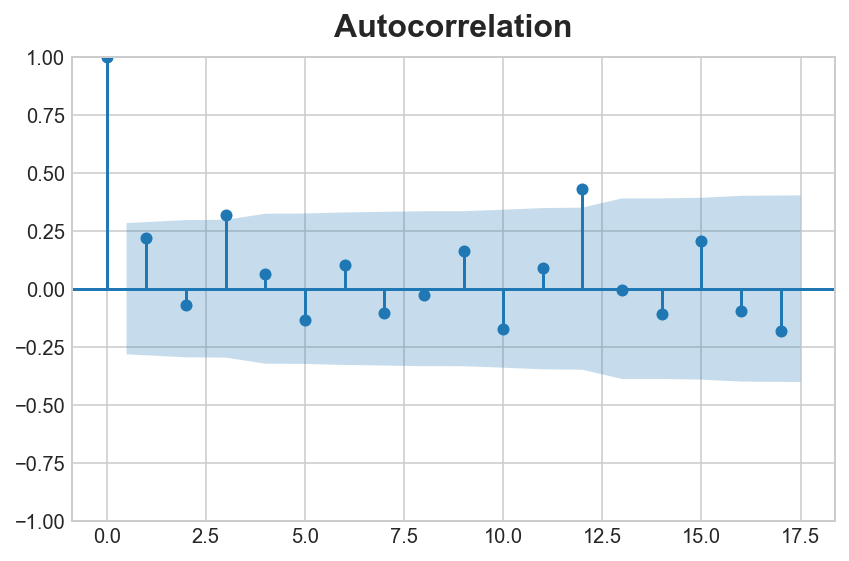

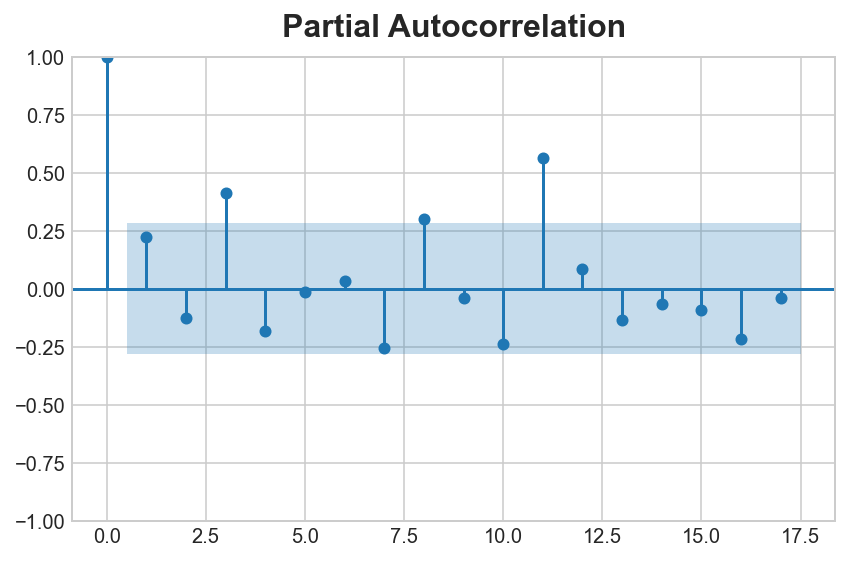

In [341]:
# look at ACF and PACF
plot_acf(ts)
plot_pacf(ts, method='yw')
None

In [342]:
# quick test for stationarity
## Adf Test
print(f"ADF {ndiffs(ts, test='adf')}")  # 0

# KPSS test
print(f"KPSS {ndiffs(ts, test='kpss')}")  # 1

# PP test:
print(f"PP {ndiffs(ts, test='pp')}") # 0

ADF 1
KPSS 1
PP 0


Now ADF test shows 1 as well. It means that the monthly resampling returns non-stationary data and in our ARIMA model we have to set the middle parameter `d=1`. Looking at autocorrelation we set `p=3` and `p=12` first and then try other combinations and check the `auto_arima` suggestions.

In [346]:
baseline = ts.mean()
predictions_validate = validate.purchase_amount.resample('M').sum().to_frame()
predictions_validate['baseline'] = ts.mean()
baseline # 4_574_450.59

19917920.290833335

In [347]:
print(f'RMSE baseline validate: \
    {mean_squared_error(predictions_validate.purchase_amount, predictions_validate.baseline) ** 0.5}')

RMSE baseline validate:     5699593.169414591


In [348]:
parameters = pd.DataFrame(columns=['p', 'd', 'q', 'rmse'])

In [403]:
model = ARIMA(ts, order=(2, 1, 3))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:        purchase_amount   No. Observations:                   48
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -792.880
Date:                Sat, 28 Jan 2023   AIC                           1597.761
Time:                        19:51:09   BIC                           1608.862
Sample:                    01-31-2018   HQIC                          1601.938
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9979      0.072    -13.955      0.000      -1.138      -0.858
ar.L2         -0.9369      0.090    -10.456      0.000      -1.113      -0.761
ma.L1          0.6248      0.244      2.565      0.0

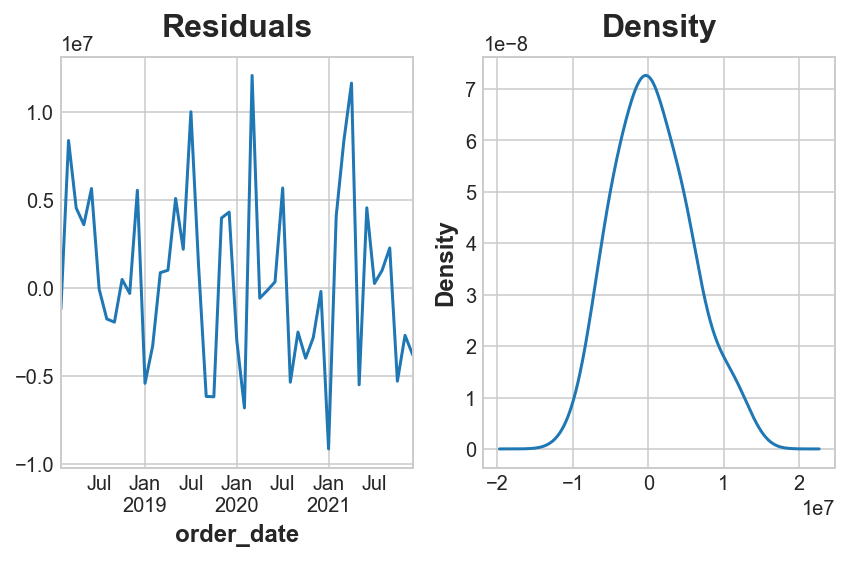

In [404]:
# plot residuals
residuals = fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1]);

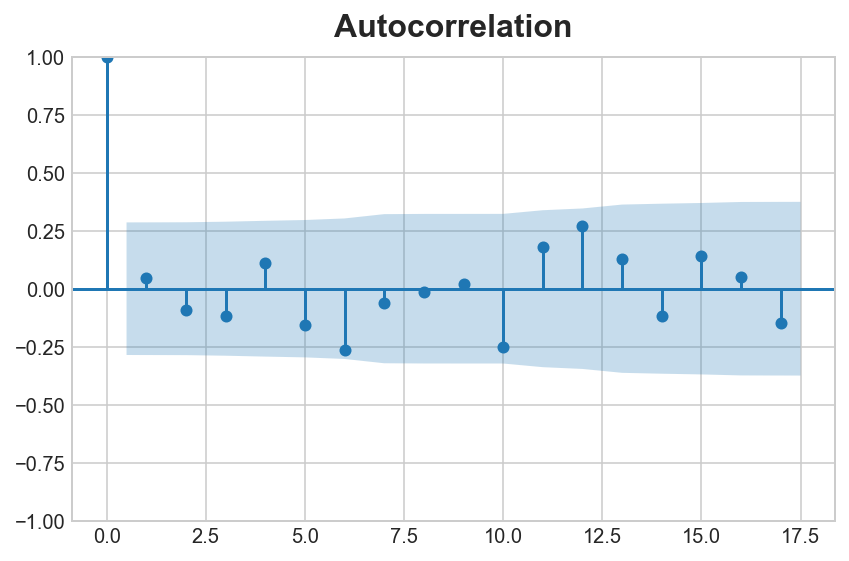

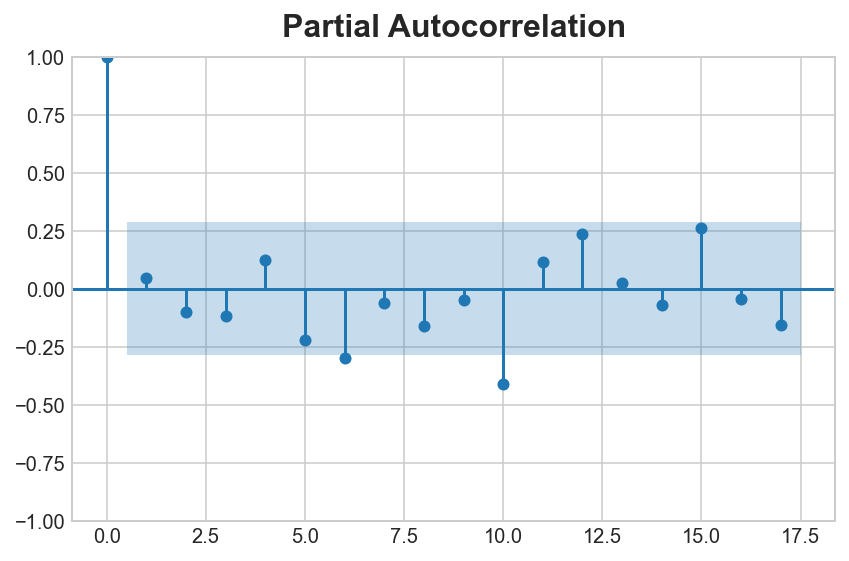

In [405]:
# plot residuals autocorrelation
plot_acf(residuals)
plot_pacf(residuals, method='yw')
None

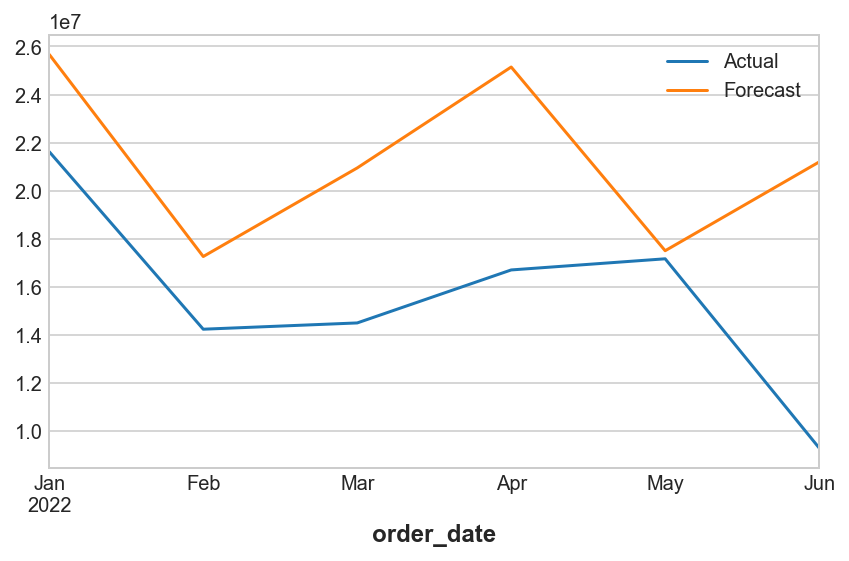

In [406]:
forecast = fit.forecast(len(validate.purchase_amount.resample('M').sum()))
validate.purchase_amount.resample('M').sum().plot(label='Actual')
forecast.plot(label='Forecast')
plt.legend()
plt.show()

In [407]:
parameters.loc[len(parameters)+1] = [2, 1, 3, 
                                   np.sqrt(mean_squared_error(predictions_validate.purchase_amount, forecast))]

In [408]:
parameters

,p,d,q,rmse
1,3.00,1.00,0.00,"5,215,443.09"
2,12.00,1.00,0.00,"8,843,970.25"
3,12.00,1.00,1.00,"10,085,978.08"
4,12.00,1.00,1.00,"7,458,982.16"
5,1.00,1.00,1.00,"7,458,982.16"
6,2.00,1.00,1.00,"5,216,125.30"
7,3.00,1.00,1.00,"5,240,504.68"
8,3.00,2.00,0.00,"5,322,776.51"
9,2.00,1.00,0.00,"5,415,028.38"
10,2.00,1.00,3.00,"6,828,068.86"


In [ ]:
# auto arima -> 2, 1, 0; 2, 1, 3. worse than our intuitive parameters: 3, 1, 0

In [409]:
auto_arima = pm.auto_arima(ts, stepwise=False, stationary=False, seasonal=False)
print(auto_arima)
auto_arima.summary()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/

 ARIMA(2,1,3)(0,0,0)[1] intercept


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -792.444
Date:                Sat, 28 Jan 2023   AIC                           1598.888
Time:                        19:51:43   BIC                           1611.839
Sample:                    01-31-2018   HQIC                          1603.762
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.687e+05   5.24e+05      0.895      0.371   -5.58e+05     1.5e+06
ar.L1         -0.9714      0.137     -7.070      0.000      -1.241      -0.702
ar.L2         -0.8797      0.131     -6.712      0.000      -1.137      -0.623
ma.L1          0.3746      0.382      0.980      0.327      -0.375       1.124
ma.L2         -0.2178      0.313     -0.697      0.486      -0.830       0.395
ma.L3         -0.8549      0.290     -2.946      0.003      -1.424      -0.286
sigma2      3.218e+13      0.007   4.86e+15      0.000    3.22e+13    3.22e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.35   Prob(JB):                         0.88
Heteroskedasticity (H):               1.84   Skew:                            -0.03
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.73e+31. Standard errors may be unstable.
"""

<div class="alert alert-warning">
    
## SUBGROUPS

In [19]:
k_12, local_gov, state_agency, higher_ed, other = create_customertype_subgroups(train)
k_12v, local_govv, state_agencyv, higher_edv, otherv = create_customertype_subgroups(validate)
k_12t, local_govt, state_agencyt, higher_edt, othert = create_customertype_subgroups(test)

In [410]:
x1, x2, x3, x4, x5 = k_12.purchase_amount.resample('W').sum(),\ #x1 schools distr
                    local_gov.purchase_amount.resample('W').sum(),\ #x2 local gov
                    state_agency.purchase_amount.resample('W').sum(),\ #x3 state agency
                    higher_ed.purchase_amount.resample('W').sum(),\ #x4 h edu
                    other.purchase_amount.resample('W').sum() # x5 other
y1, y2, y3, y4, y5 = k_12v.purchase_amount.resample('W').sum(),\
                    local_govv.purchase_amount.resample('W').sum(),\
                    state_agencyv.purchase_amount.resample('W').sum(),\
                    higher_edv.purchase_amount.resample('W').sum(),\
                    otherv.purchase_amount.resample('W').sum()
z1, z2, z3, z4, z5 = k_12t.purchase_amount.resample('W').sum(),\
                    local_govt.purchase_amount.resample('W').sum(),\
                    state_agencyt.purchase_amount.resample('W').sum(), \
                    higher_edt.purchase_amount.resample('W').sum(),\
                    othert.purchase_amount.resample('W').sum()

### ARIMA FOR LOCAL GOVERMENTS, WEEKLY RESAMPLING

In [411]:
ts = x2

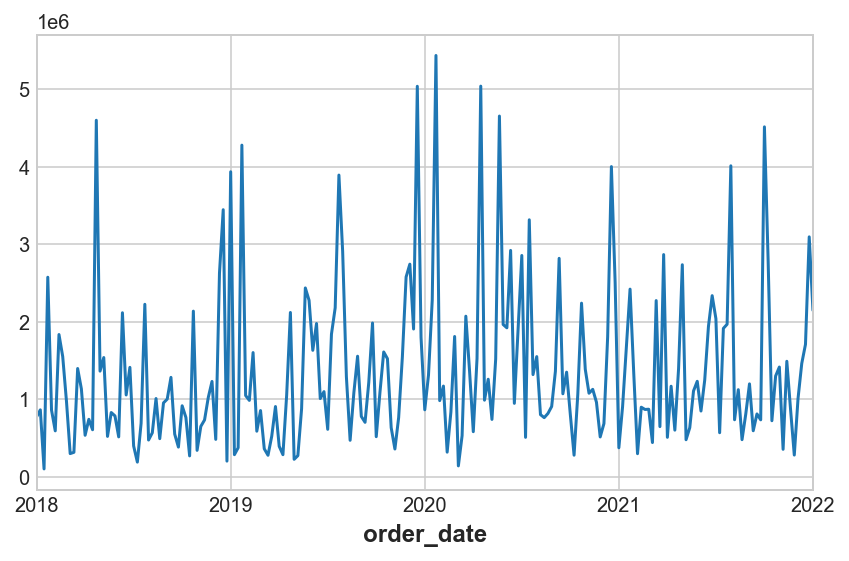

In [412]:
ts.plot();

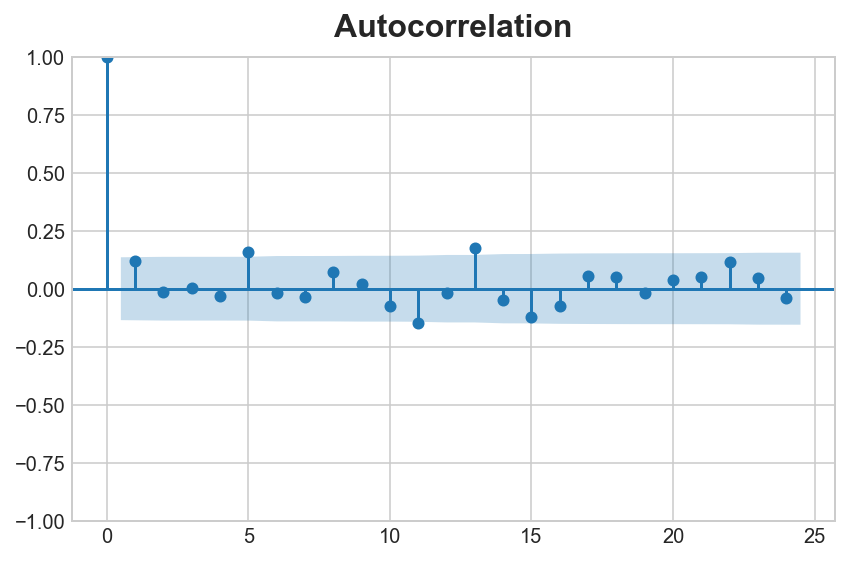

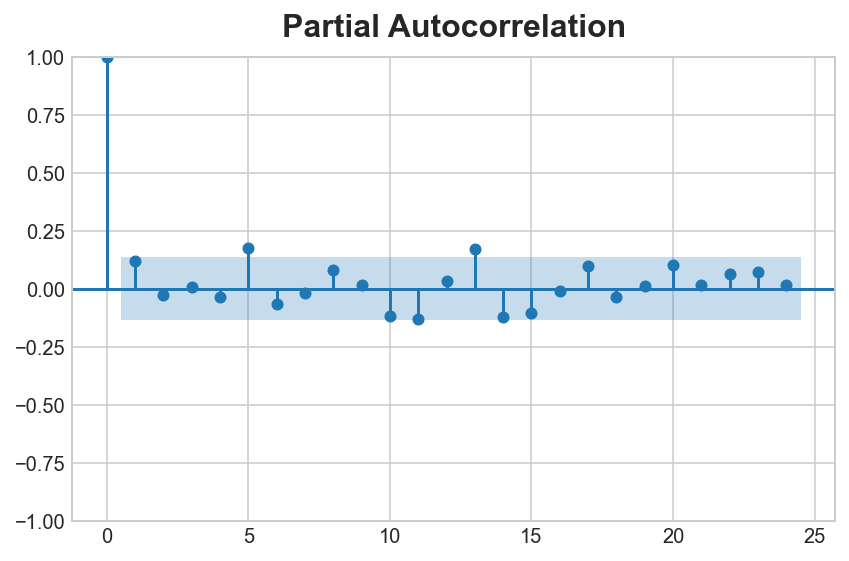

In [413]:
# look at ACF and PACF
plot_acf(ts)
plot_pacf(ts, method='yw')
None

In [414]:
# quick test for stationarity
## Adf Test
print(f"ADF {ndiffs(ts, test='adf')}")  # 0

# KPSS test
print(f"KPSS {ndiffs(ts, test='kpss')}")  # 0

# PP test:
print(f"PP {ndiffs(ts, test='pp')}") # 0

ADF 0
KPSS 0
PP 0


In [421]:
adfuller(ts)[1] # stationary

8.96972511394739e-24

In [420]:
kpss?

In [422]:
kpss(ts, regression='ct')[0] # stationary around the trend

0.14020465479542688

In [437]:
baseline = ts.mean()
predictions_validate = local_govv.purchase_amount.resample('W').sum().to_frame()
predictions_validate['baseline'] = ts.mean()
baseline # 1_361_457

1361456.997177034

In [438]:
print(f'RMSE baseline validate: \
    {mean_squared_error(predictions_validate.purchase_amount, predictions_validate.baseline) ** 0.5}')

RMSE baseline validate:     792498.8176168003


In [425]:
parameters = pd.DataFrame(columns=['p', 'd', 'q', 'rmse'])

In [470]:
model = ARIMA(ts, order=(0, 1, 1))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:        purchase_amount   No. Observations:                  209
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3180.048
Date:                Sat, 28 Jan 2023   AIC                           6364.096
Time:                        20:20:15   BIC                           6370.771
Sample:                    01-07-2018   HQIC                          6366.795
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9673      0.023    -41.928      0.000      -1.013      -0.922
sigma2      1.336e+12    2.4e-15   5.56e+26      0.000    1.34e+12    1.34e+12
Ljung-Box (L1) (Q):                   1.71   Jarque-

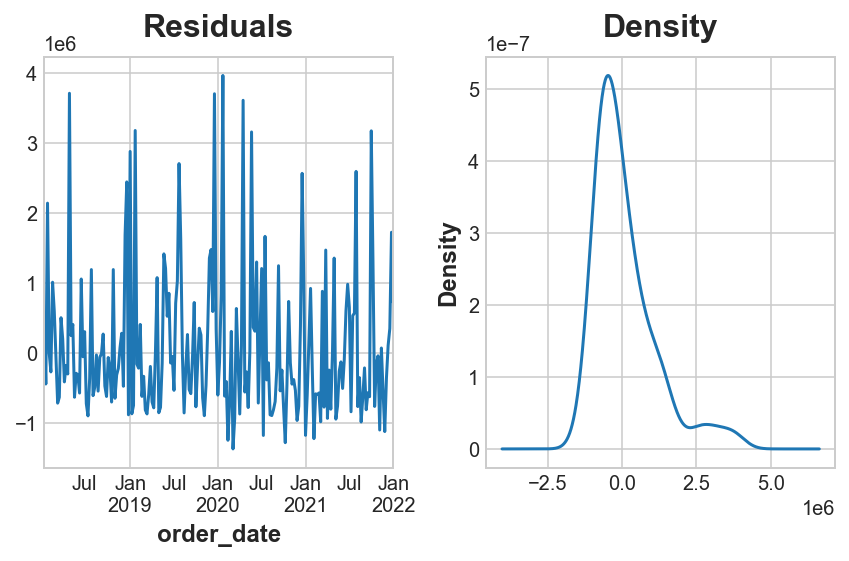

In [471]:
# plot residuals
residuals = fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1]);

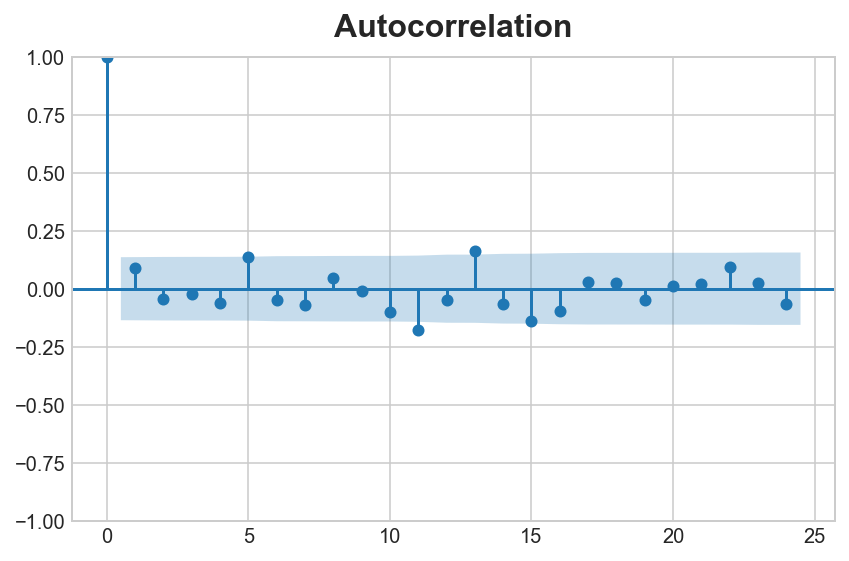

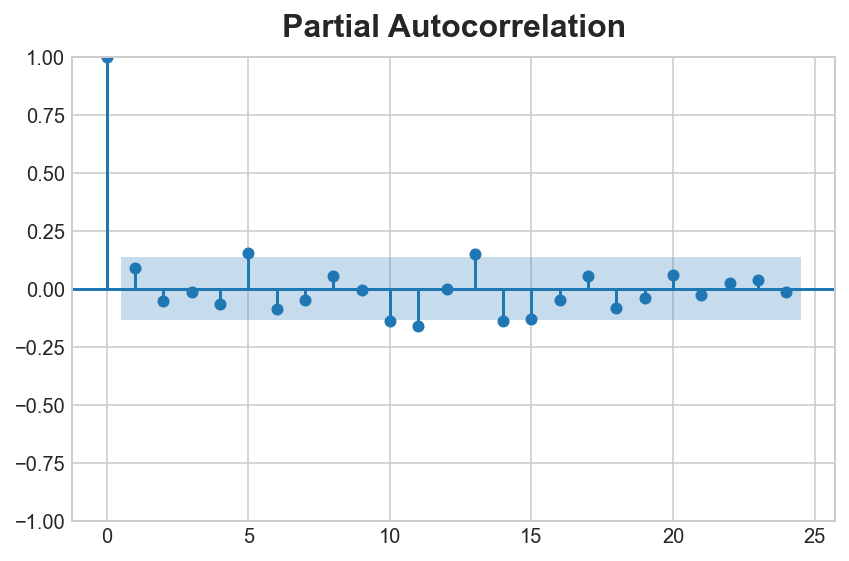

In [472]:
# plot residuals autocorrelation
plot_acf(residuals)
plot_pacf(residuals, method='yw')
None

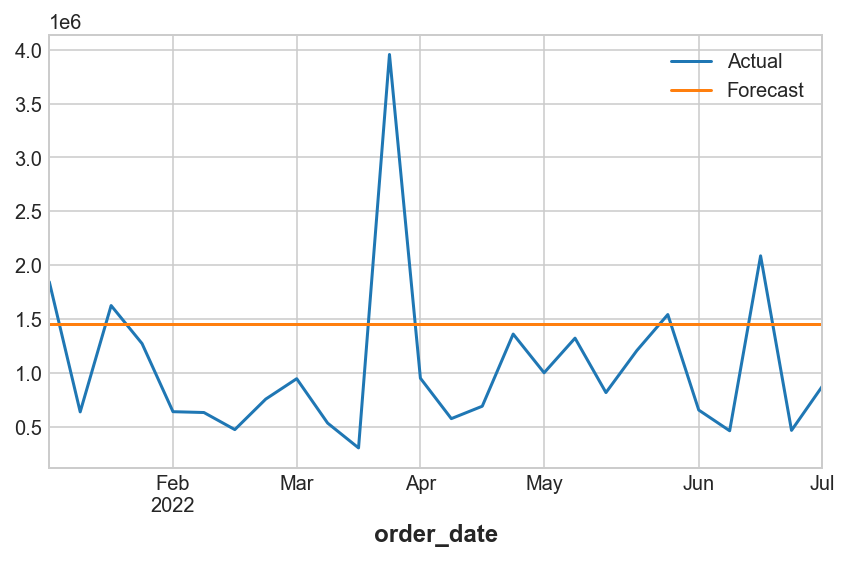

In [473]:
forecast = fit.forecast(len(local_govv.purchase_amount.resample('W').sum()))
local_govv.purchase_amount.resample('W').sum().plot(label='Actual')
forecast.plot(label='Forecast')
plt.legend()
plt.show()

In [474]:
forecast

2022-01-09   1,451,313.86
2022-01-16   1,451,313.86
2022-01-23   1,451,313.86
2022-01-30   1,451,313.86
2022-02-06   1,451,313.86
2022-02-13   1,451,313.86
2022-02-20   1,451,313.86
2022-02-27   1,451,313.86
2022-03-06   1,451,313.86
2022-03-13   1,451,313.86
2022-03-20   1,451,313.86
2022-03-27   1,451,313.86
2022-04-03   1,451,313.86
2022-04-10   1,451,313.86
2022-04-17   1,451,313.86
2022-04-24   1,451,313.86
2022-05-01   1,451,313.86
2022-05-08   1,451,313.86
2022-05-15   1,451,313.86
2022-05-22   1,451,313.86
2022-05-29   1,451,313.86
2022-06-05   1,451,313.86
2022-06-12   1,451,313.86
2022-06-19   1,451,313.86
2022-06-26   1,451,313.86
2022-07-03   1,451,313.86
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [475]:
parameters.loc[len(parameters)+1] = [0, 1, 1, 
                                   np.sqrt(mean_squared_error(predictions_validate.purchase_amount, forecast))]

In [476]:
parameters

,p,d,q,rmse
1,5.00,0.00,0.00,"804,759.26"
2,0.00,0.00,5.00,"803,810.40"
3,2.00,0.00,2.00,"797,524.26"
4,0.00,0.00,1.00,"790,943.62"
5,0.00,1.00,1.00,"830,456.42"


In [463]:
auto_arima = pm.auto_arima(ts, stepwise=False, stationary=True, seasonal=True)
print(auto_arima)
auto_arima.summary()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/

 ARIMA(0,0,1)(0,0,0)[1] intercept


/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3189.500
Date:                Sat, 28 Jan 2023   AIC                           6384.999
Time:                        20:15:13   BIC                           6395.026
Sample:                    01-07-2018   HQIC                          6389.053
                         - 01-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.343e+06   8.11e+04     16.571      0.000    1.18e+06     1.5e+06
ma.L1          0.1236      0.076      1.616      0.106      -0.026       0.273
sigma2      1.059e+12      0.074   1.43e+13      0.000    1.06e+12    1.06e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               160.56
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             1.62
Prob(H) (two-sided):                  0.49   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.51e+27. Standard errors may be unstable.
"""

Looks like ARIMA doesn't work with subsets.

In [38]:
import stat_models_d as stmd

In [189]:
reload(stmd)

<module 'stat_models_d' from '/Users/nadina/codeup-data-science/cisco-time-series-analysis/nadia_docs/stat_models_d.py'>

In [190]:
stmd.show_ma_baseline_scores()

,model_name,train_score,validate_score
0,baseline,877795,810253
1,Moving Average 2,585705,523689
2,Exp Moving Average 2,346359,313873


In [191]:
stmd.create_arima_models()

,model_name,train_score,validate_score
0,baseline,877795,810253
1,Moving Average 2,585705,523689
2,Exp Moving Average 2,346359,313873
3,"ARIMA 1,0,0",None,810031
4,"ARIMA 2,0,0",None,810169
5,"ARIMA 0,0,2",None,810129
6,"ARIMA 0,0,5",None,810848


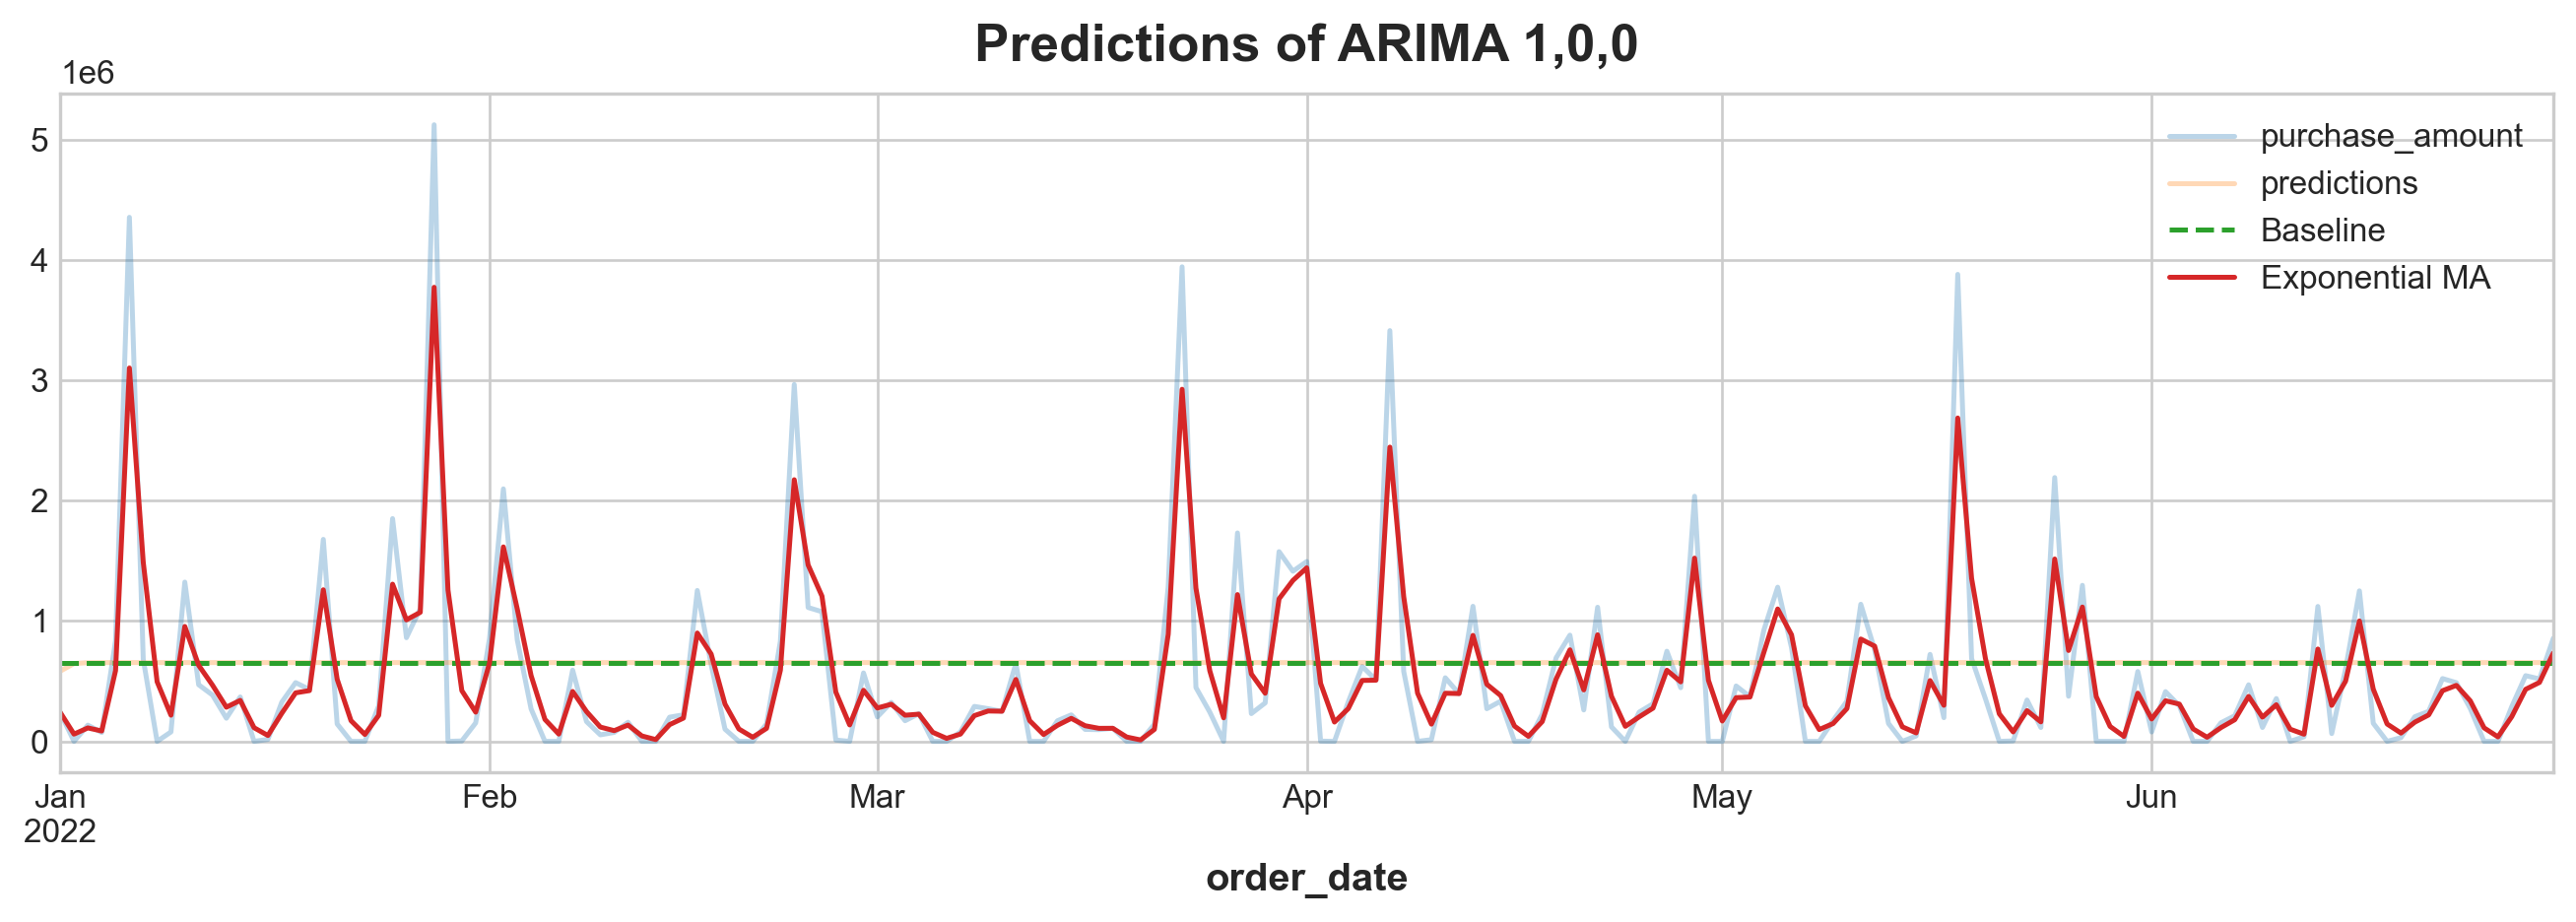

In [192]:
stmd.model_arima(show_viz=True)

In [194]:
stmd.create_prophet()

13:38:51 - cmdstanpy - INFO - Chain [1] start processing
13:38:51 - cmdstanpy - INFO - Chain [1] done processing
13:38:52 - cmdstanpy - INFO - Chain [1] start processing
13:38:52 - cmdstanpy - INFO - Chain [1] done processing
13:38:52 - cmdstanpy - INFO - Chain [1] start processing
13:38:52 - cmdstanpy - INFO - Chain [1] done processing
13:38:52 - cmdstanpy - INFO - Chain [1] start processing
13:38:53 - cmdstanpy - INFO - Chain [1] done processing
13:38:53 - cmdstanpy - INFO - Chain [1] start processing
13:38:53 - cmdstanpy - INFO - Chain [1] done processing
13:38:53 - cmdstanpy - INFO - Chain [1] start processing
13:38:53 - cmdstanpy - INFO - Chain [1] done processing
13:38:54 - cmdstanpy - INFO - Chain [1] start processing
13:38:54 - cmdstanpy - INFO - Chain [1] done processing


In [195]:
stmd.scores.sort_values(by='validate_score')

,model_name,train_score,validate_score
2,Exp Moving Average 2,346359,313873
1,Moving Average 2,585705,523689
8,Prophet,770512,767104
12,Linear Prophet 0.6,766774,801071
14,Linear Prophet 0.8,766791,801547
13,Linear Prophet 0.7,766811,802029
11,Linear Prophet 0.5,766778,802548
9,Linear Prophet 0.2,766992,806205
10,Linear Prophet 0.3,766975,808076
3,"ARIMA 1,0,0",None,810031


In [174]:
import prophet
from prophet import Prophet

In [148]:
def get_prophet_data(df:pd.DataFrame):
    '''
    Creates train and test data sets for the final model implementation 
    Parameters:
        df: pd.DataFrame, clean original or summary data frame before the split
    '''
    # make different split. train now includes data from train and validation sets
    #train = df.loc[:'2022-06'].copy() 
    #test = df.loc['2022-07':].copy()

    # prepare data frames for the Prophet model
    pr_train = validate.purchase_amount.copy().resample('D').sum()\
                        .to_frame()\
                        .reset_index()\
                        .rename({'order_date':'ds', 'purchase_amount':'y'}, axis=1)
    pr_test = test.purchase_amount.copy().resample('D').sum()\
                        .to_frame()\
                        .reset_index()\
                        .rename({'order_date':'ds', 'purchase_amount':'y'}, axis=1)
    return pr_train, pr_test

In [140]:
stmd.baseline

654835.7355890411

In [141]:
def run_test_model(df):
    '''
    
    '''
    pr_train, pr_test = get_prophet_data(df)
    # set the length of forecast
    period = len(pr_test)
    model = Prophet(growth='flat', interval_width=0.95)
    # fit on train
    model.fit(pr_train)
    # make forecast
    # periods = len of validation of test sets. 181 for daily forecasts, 27 for weekly
    future = model.make_future_dataframe(periods=period, freq='D')
    forecast = model.predict(future)
    # save forecast to prediction data frame and evaluate them
    model_name = 'Prophet'
    forecast_train = forecast.iloc[0:len(pr_train)].yhat.tolist()
    forecast_test = forecast.iloc[len(pr_train):].yhat.tolist()
    pr_train['forecast'] = forecast_train
    pr_test['forecast'] = forecast_test
    pr_test['baseline'] = stmd.baseline
    
    return pr_train, pr_test


In [158]:
def get_test_scores(pr_test):
    '''
    
    '''
    
    RMSE_prohet = np.sqrt(mean_squared_error(pr_test.y, pr_test.forecast))
    RMSE_baseline = np.sqrt(mean_squared_error(pr_test.y, pr_test.baseline))
    # set model name as an index in scores data frame
    #stmd.scores.set_index('model_name', inplace=True)
    test_scores = pd.DataFrame({
                         'Baseline':[ stmd.scores.loc['baseline', 'train_score'], 
                                     stmd.scores.loc['baseline', 'validate_score'], RMSE_baseline],
                         'Prophet':[ stmd.scores.loc['Prophet', 'train_score'],
                                    stmd.scores.loc['Prophet', 'validate_score'], RMSE_prohet]
                            },index=[ 'Train RMSE', 'Validate RMSE', 'Test RMSE']),
    return test_scores

In [149]:
evaluate_test_model(df)

13:09:44 - cmdstanpy - INFO - Chain [1] start processing
13:09:44 - cmdstanpy - INFO - Chain [1] done processing


,Prophet,Baseline
Train RMSE,"770,512.00","877,795.00"
Validate RMSE,"767,104.00","810,253.00"
Test RMSE,"553,131.60","586,411.40"


In [151]:
def plot_predictions(pr_test):
    '''
    Plot Prophet Predictions
    '''
    sns.set_style("whitegrid")
    ax = sns.lineplot(data=pr_test, x='ds',y='y', label='Actual values')
    ax = sns.lineplot(data=pr_test, x='ds',y='forecast', label='Model forecast')
    ax = sns.lineplot(data=pr_test, x='ds',y='baseline', label='Baseline predictions')
    ax.set(title='Model predictions on the test set')
    ax.set(yticks=[0, 500_000, 2_000_000, 3_500_000])
    ax.set(yticklabels=['0', '500K', '2M', '3.5M'])
    ax.set(ylabel='purchase_amount')
    plt.show()

In [159]:
reload(stmd)

<module 'stat_models_d' from '/Users/nadina/codeup-data-science/cisco-time-series-analysis/nadia_docs/stat_models_d.py'>

13:39:13 - cmdstanpy - INFO - Chain [1] start processing
13:39:13 - cmdstanpy - INFO - Chain [1] done processing


,Baseline,Prophet
Train RMSE,"877,795.00","770,512.00"
Validate RMSE,"810,253.00","767,104.00"
Test RMSE,"586,411.40","553,131.60"


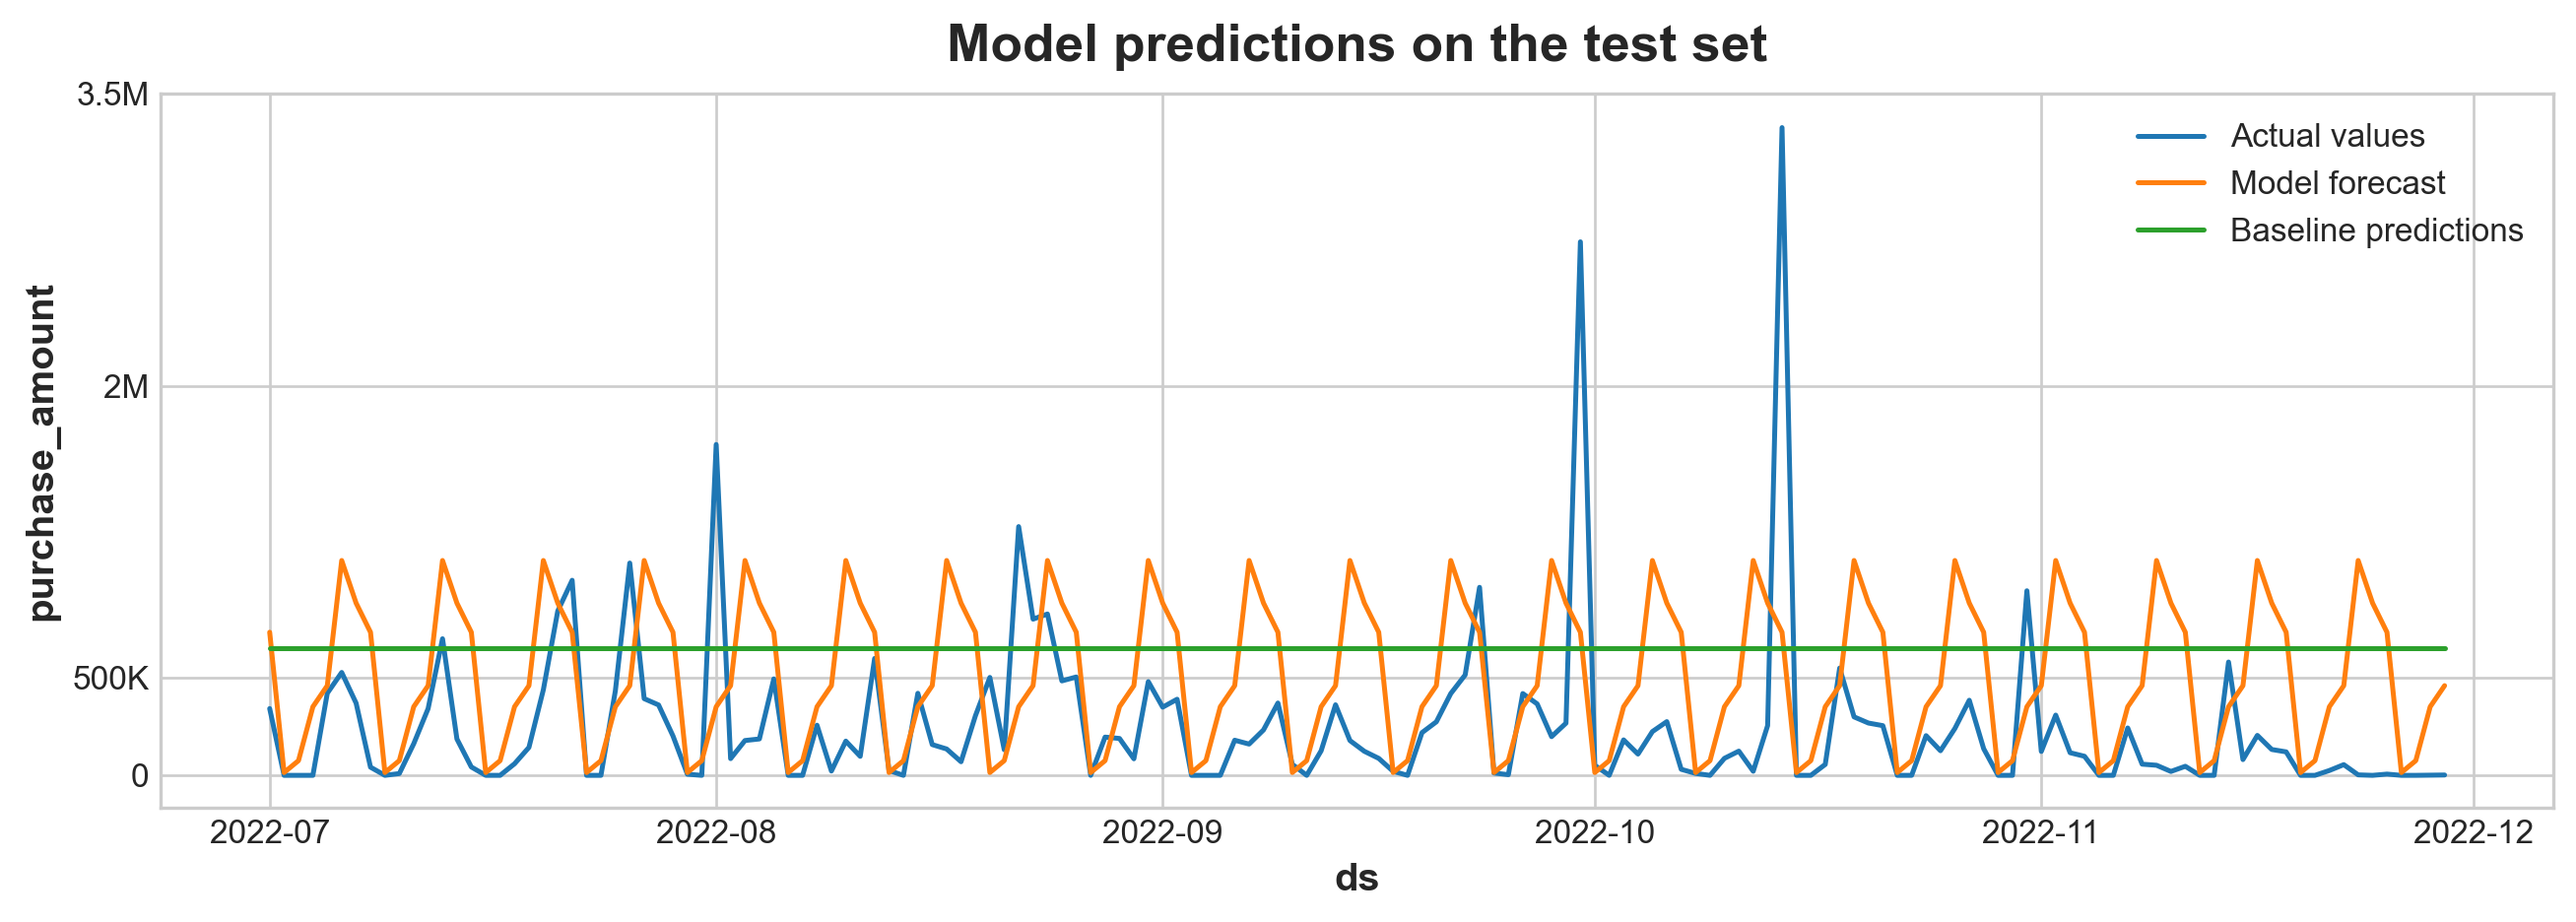

In [196]:
stmd.show_test()